#Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
file_name = "Customer_Churn_Data_Large.xlsx"
dfs = pd.read_excel(file_name, sheet_name=None)
demographic = dfs['Customer_Demographics']
transaction = dfs['Transaction_History']
service = dfs['Customer_Service']
activity = dfs['Online_Activity']
churn = dfs['Churn_Status']
datasets = {'demographic': [demographic], 'transaction': [transaction], 'service': [service], 'activity': [activity], 'churn': [churn]}

#Preprocessing

In [ ]:
for dataset, data in datasets.items():
  print(f"Missing values in {dataset} dataset:")
  print(data[0].isnull().sum())

Missing values in demographic dataset:
CustomerID       0
Age              0
Gender           0
MaritalStatus    0
IncomeLevel      0
dtype: int64
Missing values in transaction dataset:
CustomerID         0
TransactionID      0
TransactionDate    0
AmountSpent        0
ProductCategory    0
dtype: int64
Missing values in service dataset:
CustomerID          0
InteractionID       0
InteractionDate     0
InteractionType     0
ResolutionStatus    0
dtype: int64
Missing values in activity dataset:
CustomerID        0
LastLoginDate     0
LoginFrequency    0
ServiceUsage      0
dtype: int64
Missing values in churn dataset:
CustomerID     0
ChurnStatus    0
dtype: int64


In [ ]:
# Start with all unique customers from the churn dataset to ensure all customers are included
data = churn.copy()

# Left merge demographic data
data = pd.merge(data, demographic, on='CustomerID', how='left')

# Left merge transactions
data = pd.merge(data, transaction, on='CustomerID', how='left')

# Left merge customer service counts
data = pd.merge(data, service, on='CustomerID', how='left')


# Left merge online activity (LoginFrequency is chosen based on EDA insights)
data = pd.merge(data, activity, on='CustomerID', how='left')


# Set CustomerID as index
data = data.set_index('CustomerID')

# Fill any NaN values resulting from the left merges with 0
# This assumes NaN means no activity in that category for that customer
data = data.fillna(0)

# Display the first few rows and info to check the result
display(data.head())
data.info()

,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage
CustomerID,,,,,,,,,,,,,,,,
1,0,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363.0,2022-03-31 00:00:00,Inquiry,Resolved,2023-10-21,34,Mobile App
2,1,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website
2,1,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website
2,1,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website
2,1,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website


<class 'pandas.core.frame.DataFrame'>
Index: 6812 entries, 1 to 1000
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ChurnStatus       6812 non-null   int64         
 1   Age               6812 non-null   int64         
 2   Gender            6812 non-null   object        
 3   MaritalStatus     6812 non-null   object        
 4   IncomeLevel       6812 non-null   object        
 5   TransactionID     6812 non-null   int64         
 6   TransactionDate   6812 non-null   datetime64[ns]
 7   AmountSpent       6812 non-null   float64       
 8   ProductCategory   6812 non-null   object        
 9   InteractionID     6812 non-null   float64       
 10  InteractionDate   6812 non-null   object        
 11  InteractionType   6812 non-null   object        
 12  ResolutionStatus  6812 non-null   object        
 13  LastLoginDate     6812 non-null   datetime64[ns]
 14  LoginFrequency    6812 non-nu

In [ ]:
def preprocess_data(df):
    """
    Encodes categorical features and standardizes numerical features
    in a DataFrame for machine learning.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_processed = df.copy()

    # Encoding categorical features
    for col in df_processed.select_dtypes(include='object').columns:
        if col == 'Gender': # Keep both columns for Gender
             df_processed = pd.get_dummies(df_processed, columns=[col], prefix=col, dtype=int)
        elif col not in ['TransactionDate', 'InteractionDate', 'LastLoginDate', 'TransactionID', 'InteractionID']: # Exclude date columns and drop first for others
            df_processed = pd.get_dummies(df_processed, columns=[col], prefix=col, drop_first=True, dtype=int)


    # Standardizing numerical features
    # Identify numerical columns excluding CustomerID and ChurnStatus
    numerical_features = df_processed.select_dtypes(include=np.number).columns.tolist()
    if 'CustomerID' in numerical_features:
        numerical_features.remove('CustomerID')
    if 'ChurnStatus' in numerical_features:
        numerical_features.remove('ChurnStatus')

    scaler = StandardScaler()
    df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])

    # Drop original date columns if they still exist
    df_processed = df_processed.drop(columns=['TransactionDate', 'InteractionDate', 'LastLoginDate', 'TransactionID', 'InteractionID'], errors='ignore')


    return df_processed

# Apply the preprocessing function to your data
data_preprocessed = preprocess_data(data)

# Display the first few rows of the preprocessed data
display(data_preprocessed.head())
data_preprocessed.info()

,ChurnStatus,Age,AmountSpent,LoginFrequency,Gender_F,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,...,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Complaint,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Resolved,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
CustomerID,,,,,,,,,,,,,,,,,,,,,
1,0,1.225036,1.153881,0.588556,-1.052461,1.052461,-0.552930,1.859601,-0.621031,1.444487,...,1.996703,-0.491176,-0.500826,-0.59227,-0.626707,1.870652,1.236738,-0.76408,-0.742057,-0.672185
2,1,1.421298,-1.376296,-1.473886,-1.052461,1.052461,1.808548,-0.537750,-0.621031,1.444487,...,-0.500826,-0.491176,-0.500826,-0.59227,-0.626707,1.870652,1.236738,-0.76408,-0.742057,1.487685
2,1,1.421298,-0.378753,-1.473886,-1.052461,1.052461,1.808548,-0.537750,-0.621031,1.444487,...,1.996703,-0.491176,-0.500826,-0.59227,-0.626707,1.870652,1.236738,-0.76408,-0.742057,1.487685
2,1,1.421298,-1.051923,-1.473886,-1.052461,1.052461,1.808548,-0.537750,-0.621031,1.444487,...,-0.500826,2.035931,-0.500826,-0.59227,-0.626707,1.870652,1.236738,-0.76408,-0.742057,1.487685
2,1,1.421298,1.020003,-1.473886,-1.052461,1.052461,1.808548,-0.537750,-0.621031,1.444487,...,-0.500826,-0.491176,-0.500826,-0.59227,-0.626707,1.870652,1.236738,-0.76408,-0.742057,1.487685


<class 'pandas.core.frame.DataFrame'>
Index: 6812 entries, 1 to 1000
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ChurnStatus                  6812 non-null   int64  
 1   Age                          6812 non-null   float64
 2   AmountSpent                  6812 non-null   float64
 3   LoginFrequency               6812 non-null   float64
 4   Gender_F                     6812 non-null   float64
 5   Gender_M                     6812 non-null   float64
 6   MaritalStatus_Married        6812 non-null   float64
 7   MaritalStatus_Single         6812 non-null   float64
 8   MaritalStatus_Widowed        6812 non-null   float64
 9   IncomeLevel_Low              6812 non-null   float64
 10  IncomeLevel_Medium           6812 non-null   float64
 11  ProductCategory_Clothing     6812 non-null   float64
 12  ProductCategory_Electronics  6812 non-null   float64
 13  ProductCategory_Furnitu

##Feature Importance

Feature Importances:
Age                            0.237294
LoginFrequency                 0.236194
AmountSpent                    0.115753
ServiceUsage_Online Banking    0.035049
IncomeLevel_Medium             0.032206
IncomeLevel_Low                0.031014
MaritalStatus_Married          0.030439
MaritalStatus_Widowed          0.029080
MaritalStatus_Single           0.028312
ServiceUsage_Website           0.026278
ResolutionStatus_Resolved      0.025982
ResolutionStatus_Unresolved    0.025684
InteractionType_Feedback       0.024552
InteractionType_Complaint      0.023095
InteractionType_Inquiry        0.023039
Gender_M                       0.016031
Gender_F                       0.014396
ProductCategory_Electronics    0.012048
ProductCategory_Clothing       0.011309
ProductCategory_Groceries      0.011297
ProductCategory_Furniture      0.010948
dtype: float64


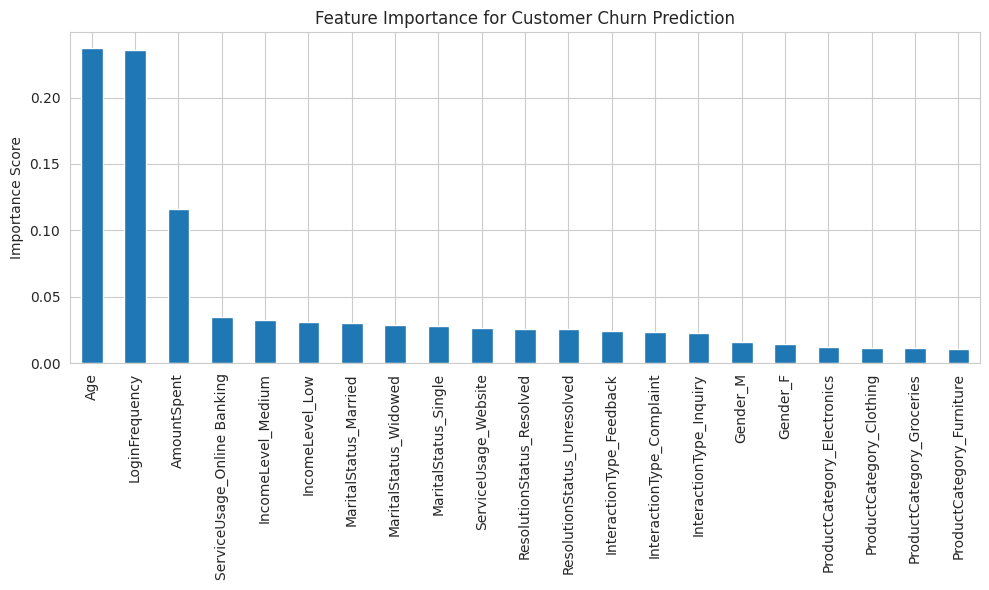

In [ ]:
def feature_importance(df):
  x = df.drop('ChurnStatus', axis=1)
  y = df['ChurnStatus']


  # Initialize and train a RandomForestClassifier
  model = RandomForestClassifier(random_state=42)
  model.fit(x, y)

  # Get feature importances
  feature_importances = pd.Series(model.feature_importances_, index=x.columns)

  # Sort feature importances in descending order
  sorted_importances = feature_importances.sort_values(ascending=False)

  # Print or visualize the feature importances
  print("Feature Importances:")
  print(sorted_importances)

  # Optional: Visualize feature importances
  plt.figure(figsize=(10, 6))
  sorted_importances.plot(kind='bar')
  plt.title('Feature Importance for Customer Churn Prediction')
  plt.ylabel('Importance Score')
  plt.tight_layout()
  plt.show()

feature_importance(data_preprocessed)

#EDA

In [ ]:
columns = list(data_preprocessed.columns)


STARTING COMPREHENSIVE EDA FOR CUSTOMER CHURN

DATA OVERVIEW

Dataset Shape: 6812 rows × 22 columns

Column Names and Types:
ChurnStatus                      int64
Age                            float64
AmountSpent                    float64
LoginFrequency                 float64
Gender_F                       float64
Gender_M                       float64
MaritalStatus_Married          float64
MaritalStatus_Single           float64
MaritalStatus_Widowed          float64
IncomeLevel_Low                float64
IncomeLevel_Medium             float64
ProductCategory_Clothing       float64
ProductCategory_Electronics    float64
ProductCategory_Furniture      float64
ProductCategory_Groceries      float64
InteractionType_Complaint      float64
InteractionType_Feedback       float64
InteractionType_Inquiry        float64
ResolutionStatus_Resolved      float64
ResolutionStatus_Unresolved    float64
ServiceUsage_Online Banking    float64
ServiceUsage_Website           float64
dtype: object

M

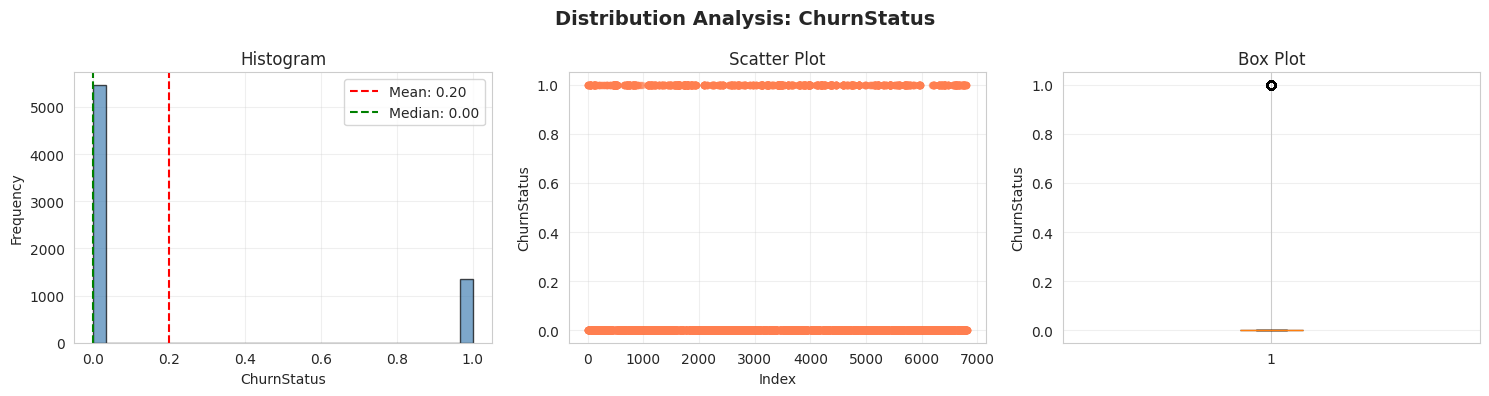


STATISTICS: ChurnStatus
Mean:     0.198
Median:   0.000
Std Dev:  0.399
Min:      0.000
Max:      1.000
Skewness: 1.512
Kurtosis: 0.287
Outliers: 1352 (19.85%)


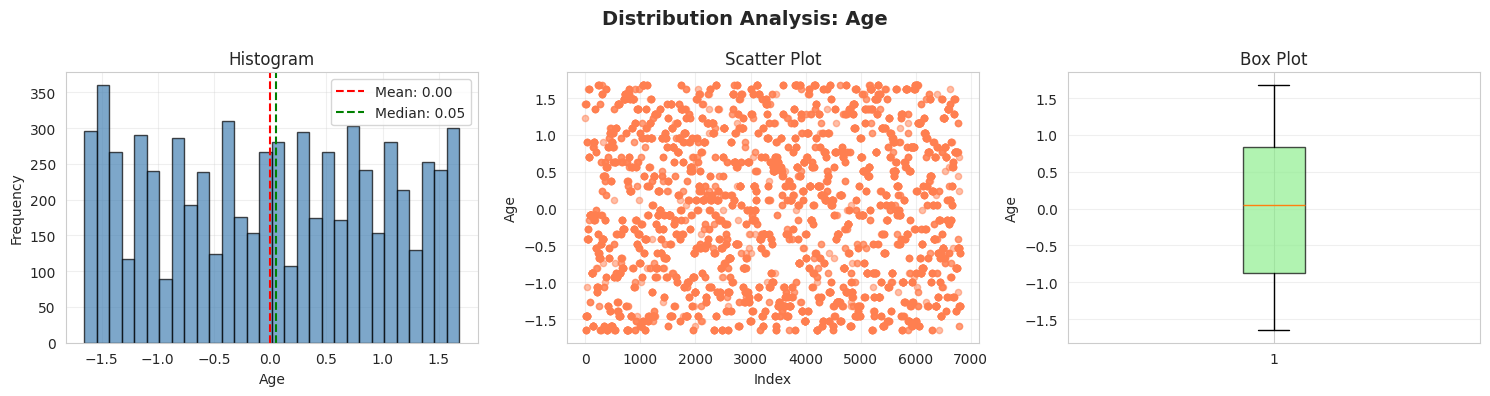


STATISTICS: Age
Mean:     0.000
Median:   0.047
Std Dev:  1.000
Min:      -1.653
Max:      1.683
Skewness: -0.012
Kurtosis: -1.226
Outliers: 0 (0.00%)


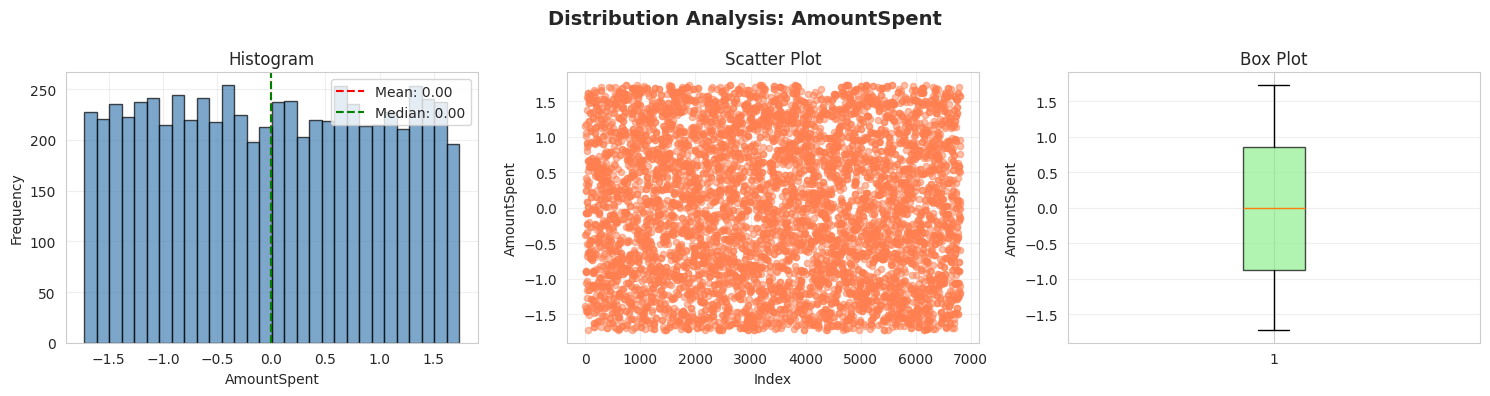


STATISTICS: AmountSpent
Mean:     0.000
Median:   0.002
Std Dev:  1.000
Min:      -1.725
Max:      1.737
Skewness: 0.007
Kurtosis: -1.213
Outliers: 0 (0.00%)


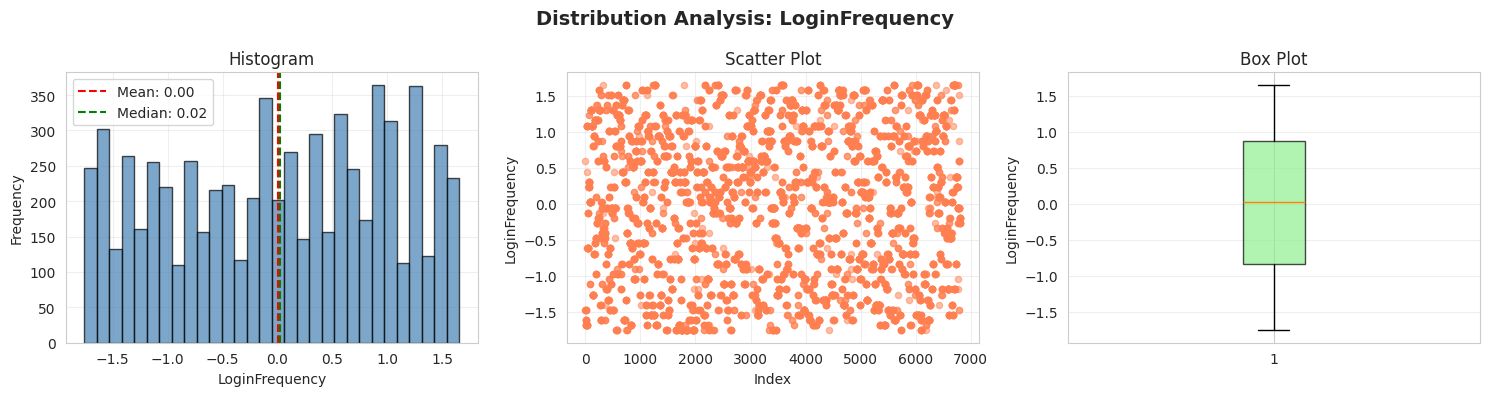


STATISTICS: LoginFrequency
Mean:     0.000
Median:   0.020
Std Dev:  1.000
Min:      -1.758
Max:      1.655
Skewness: -0.122
Kurtosis: -1.192
Outliers: 0 (0.00%)


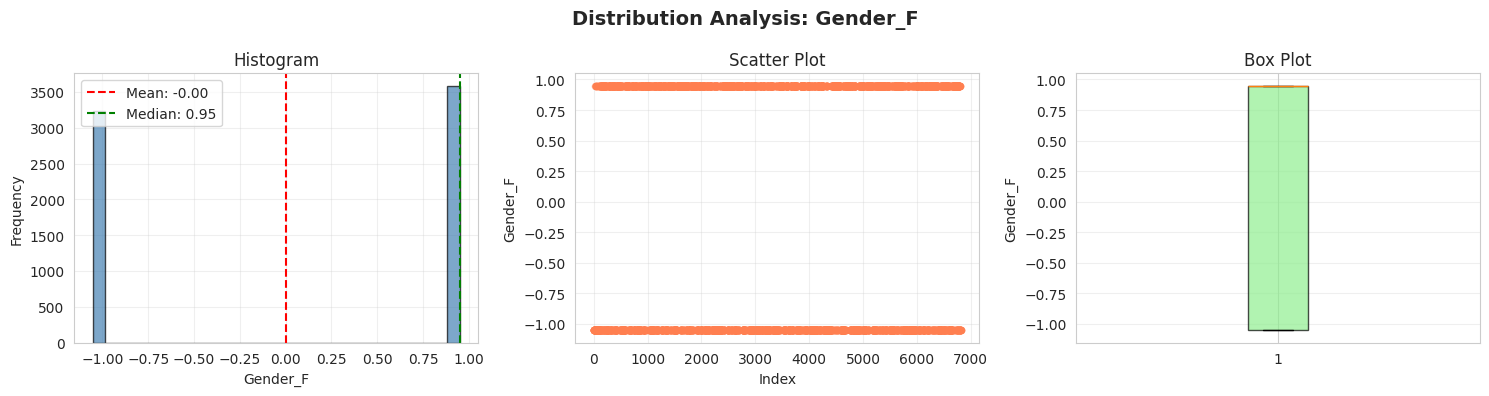


STATISTICS: Gender_F
Mean:     -0.000
Median:   0.950
Std Dev:  1.000
Min:      -1.052
Max:      0.950
Skewness: -0.102
Kurtosis: -1.990
Outliers: 0 (0.00%)


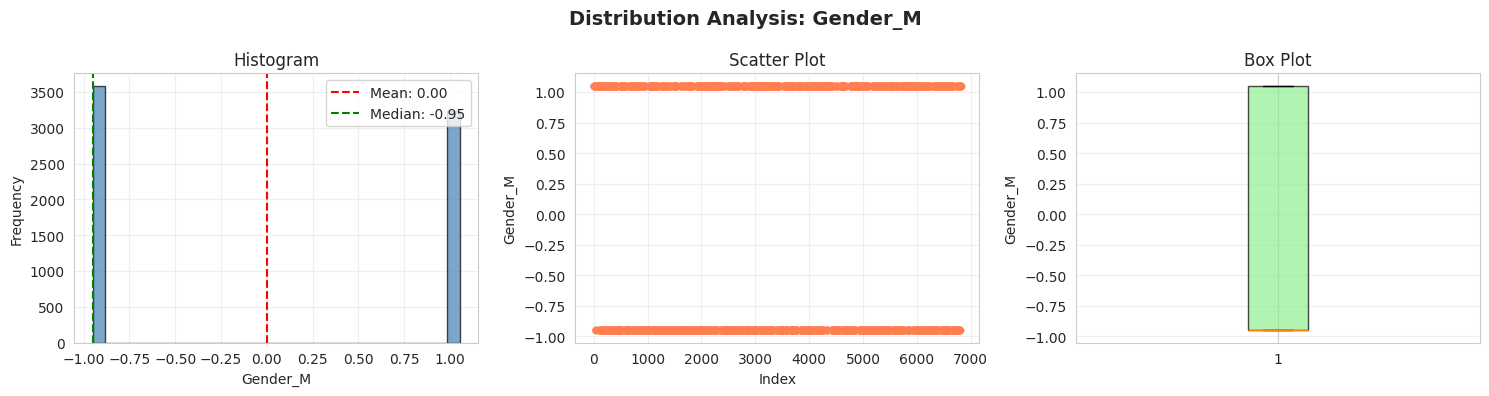


STATISTICS: Gender_M
Mean:     0.000
Median:   -0.950
Std Dev:  1.000
Min:      -0.950
Max:      1.052
Skewness: 0.102
Kurtosis: -1.990
Outliers: 0 (0.00%)


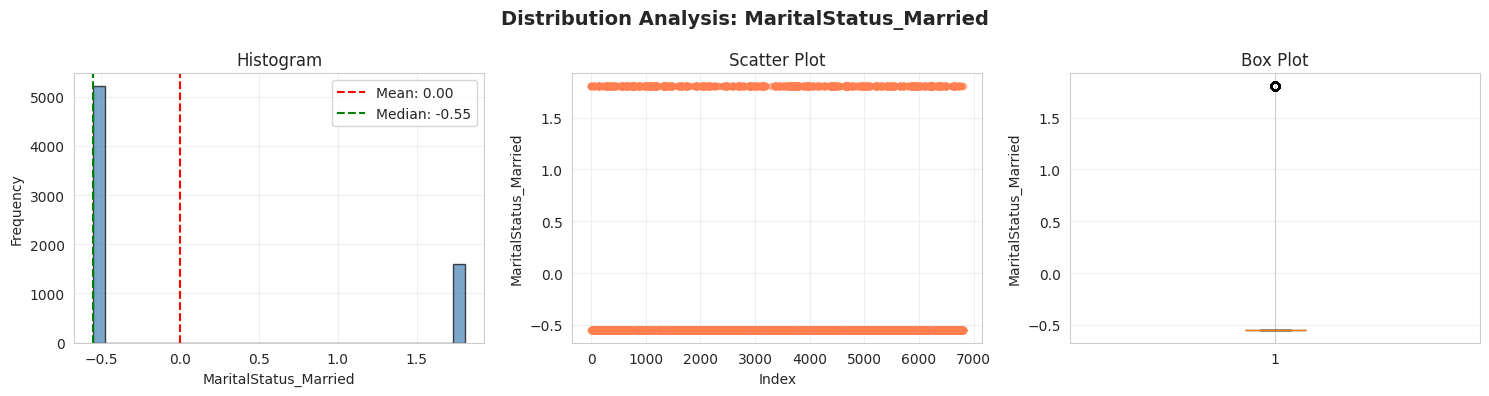


STATISTICS: MaritalStatus_Married
Mean:     0.000
Median:   -0.553
Std Dev:  1.000
Min:      -0.553
Max:      1.809
Skewness: 1.256
Kurtosis: -0.423
Outliers: 1595 (23.41%)


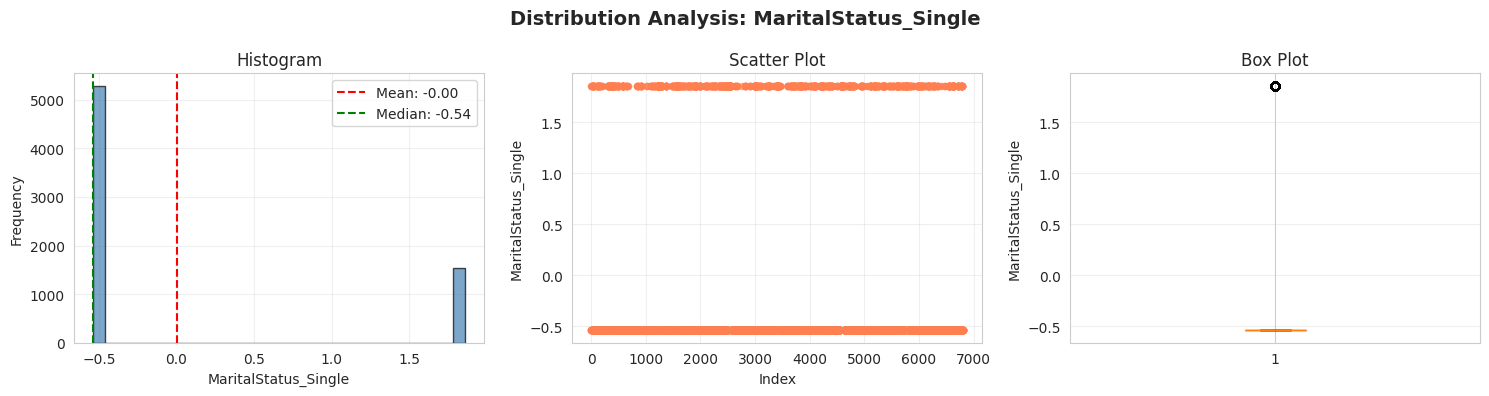


STATISTICS: MaritalStatus_Single
Mean:     -0.000
Median:   -0.538
Std Dev:  1.000
Min:      -0.538
Max:      1.860
Skewness: 1.322
Kurtosis: -0.252
Outliers: 1528 (22.43%)


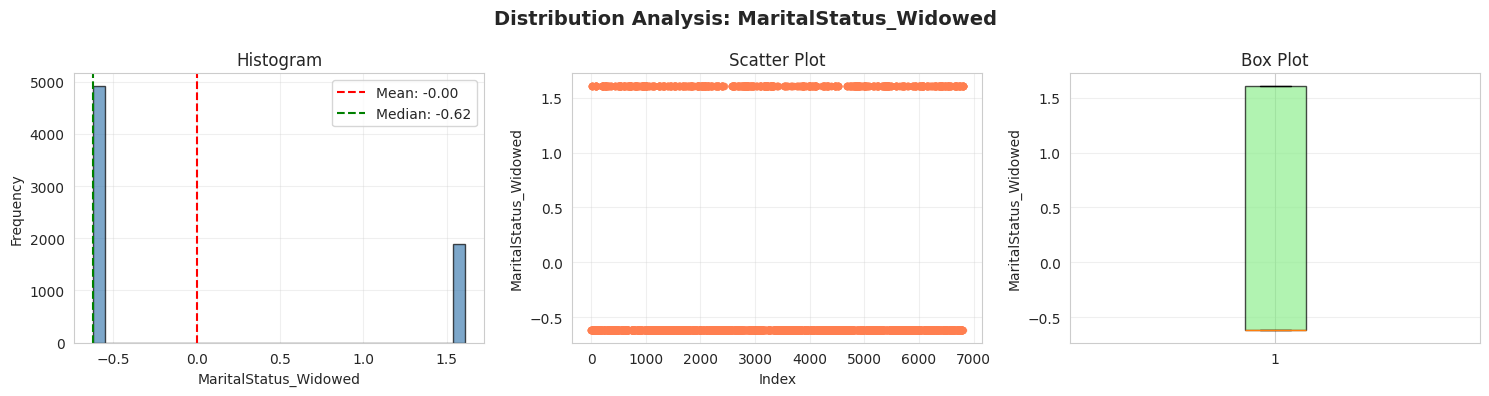


STATISTICS: MaritalStatus_Widowed
Mean:     -0.000
Median:   -0.621
Std Dev:  1.000
Min:      -0.621
Max:      1.610
Skewness: 0.989
Kurtosis: -1.021
Outliers: 0 (0.00%)


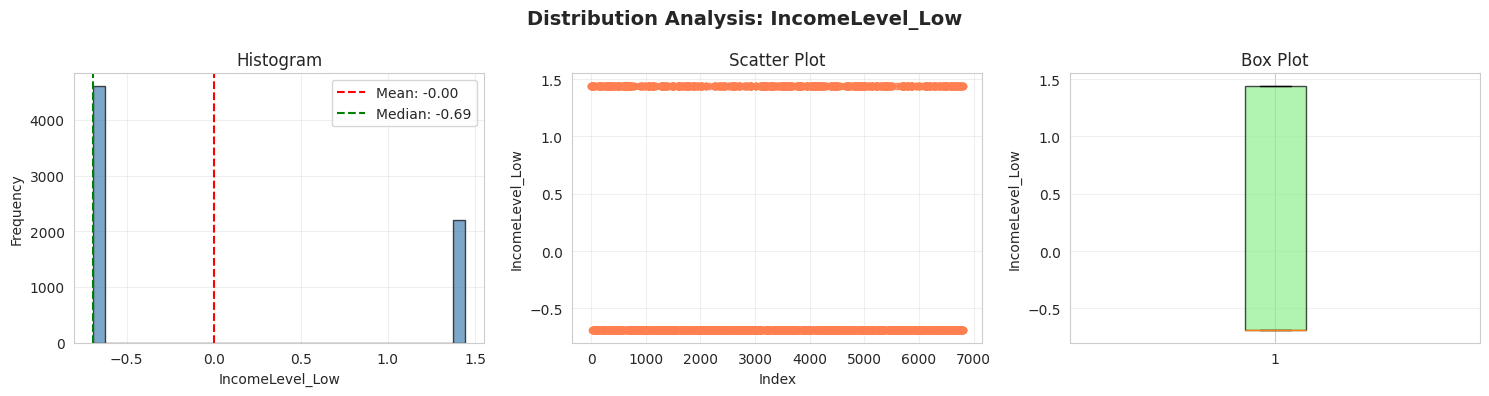


STATISTICS: IncomeLevel_Low
Mean:     -0.000
Median:   -0.692
Std Dev:  1.000
Min:      -0.692
Max:      1.444
Skewness: 0.752
Kurtosis: -1.434
Outliers: 0 (0.00%)


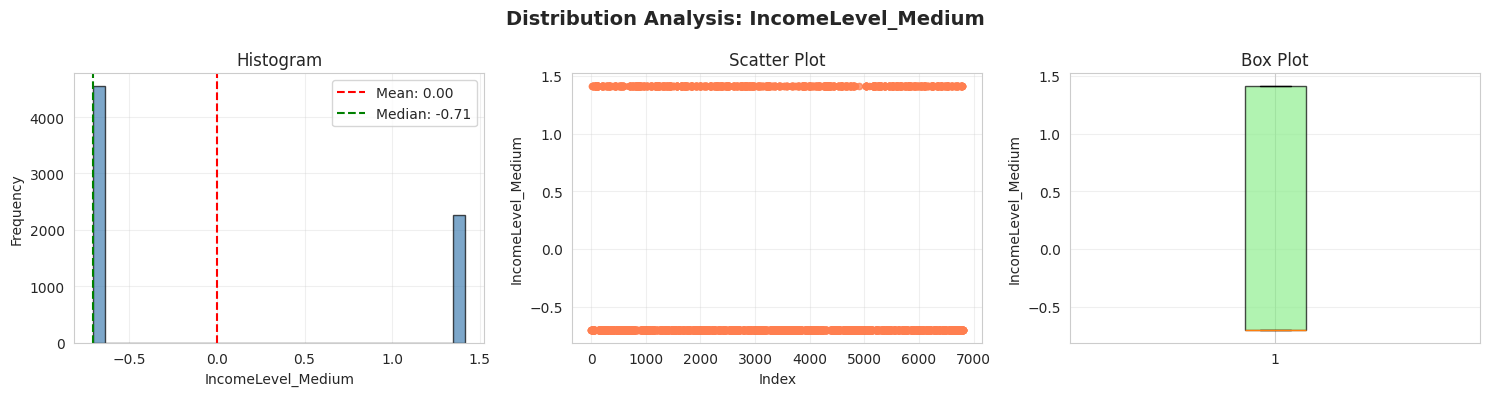


STATISTICS: IncomeLevel_Medium
Mean:     0.000
Median:   -0.706
Std Dev:  1.000
Min:      -0.706
Max:      1.417
Skewness: 0.711
Kurtosis: -1.495
Outliers: 0 (0.00%)


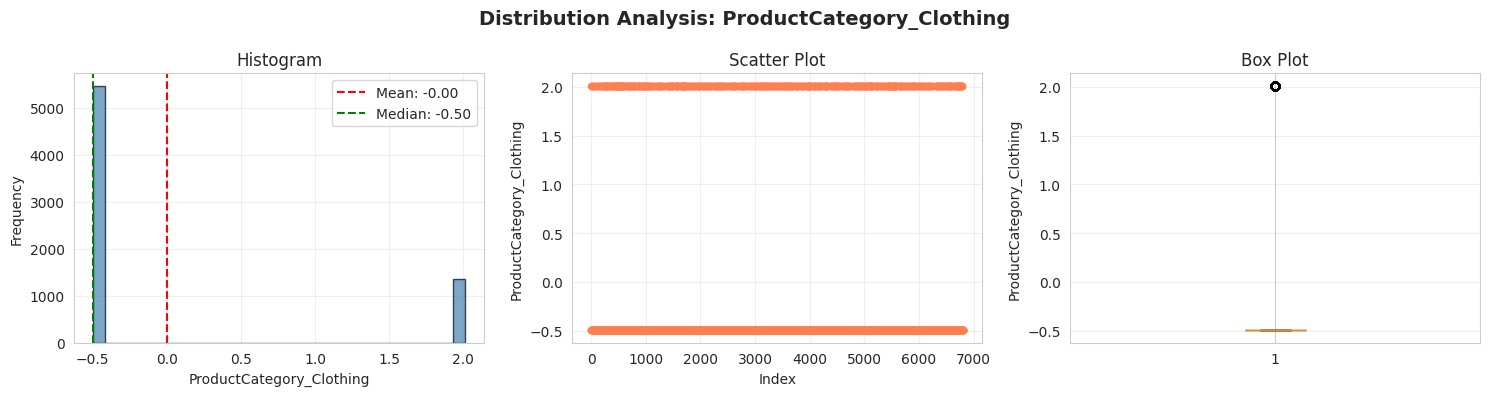


STATISTICS: ProductCategory_Clothing
Mean:     -0.000
Median:   -0.497
Std Dev:  1.000
Min:      -0.497
Max:      2.013
Skewness: 1.517
Kurtosis: 0.301
Outliers: 1348 (19.79%)


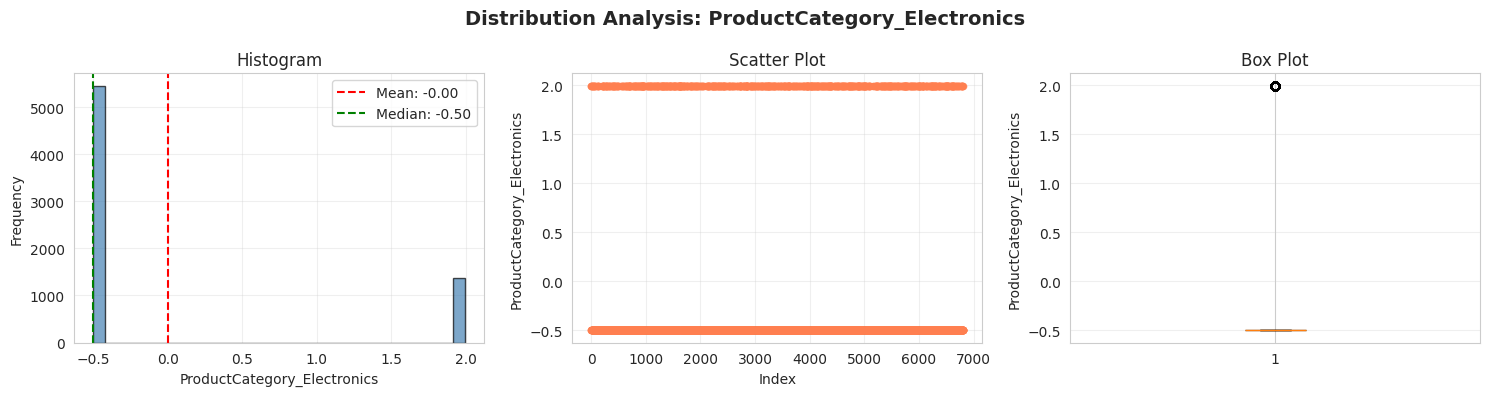


STATISTICS: ProductCategory_Electronics
Mean:     -0.000
Median:   -0.501
Std Dev:  1.000
Min:      -0.501
Max:      1.997
Skewness: 1.496
Kurtosis: 0.239
Outliers: 1366 (20.05%)


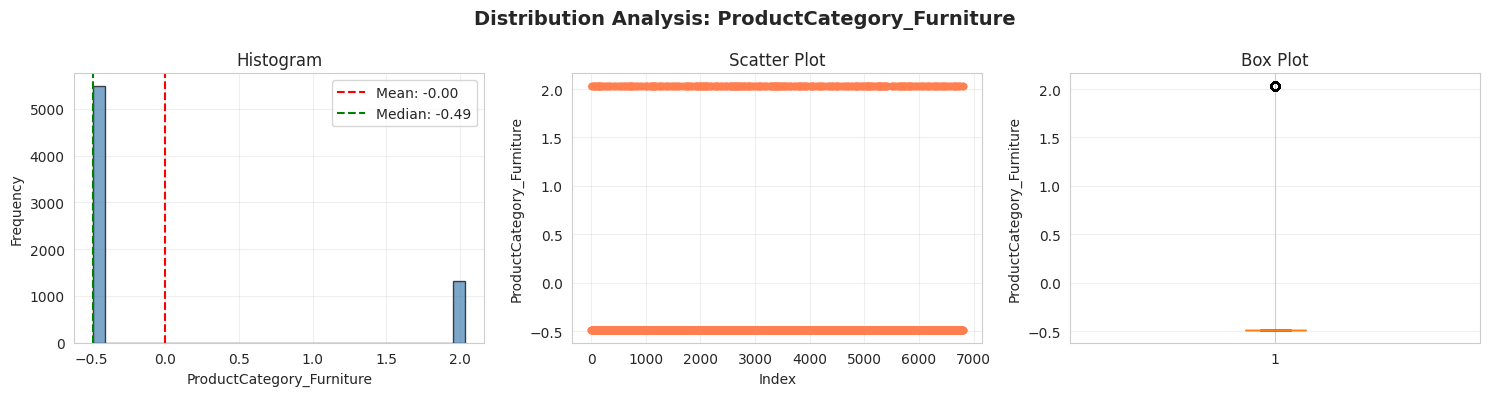


STATISTICS: ProductCategory_Furniture
Mean:     -0.000
Median:   -0.491
Std Dev:  1.000
Min:      -0.491
Max:      2.036
Skewness: 1.545
Kurtosis: 0.387
Outliers: 1324 (19.44%)


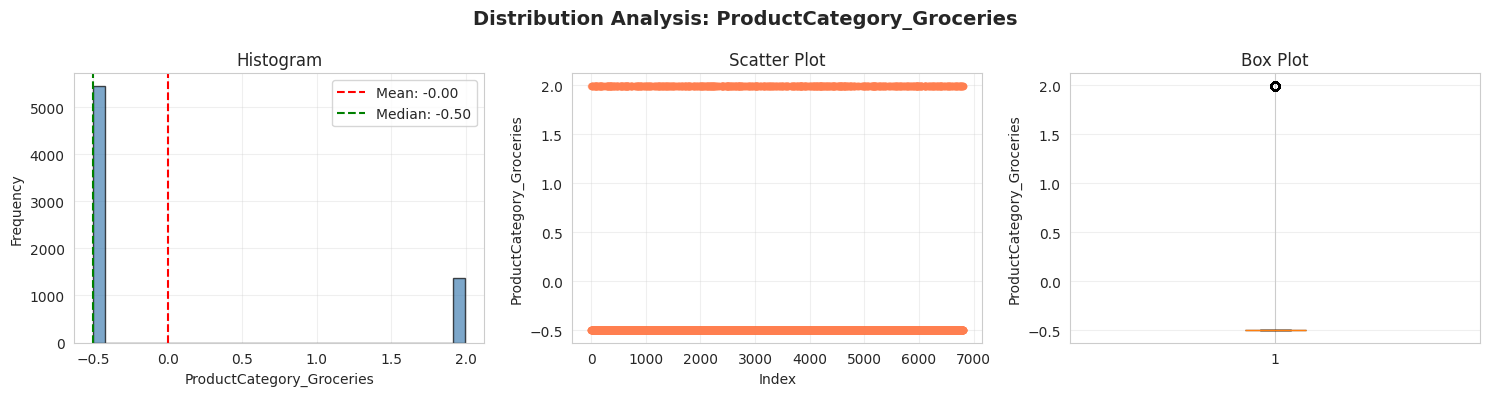


STATISTICS: ProductCategory_Groceries
Mean:     -0.000
Median:   -0.501
Std Dev:  1.000
Min:      -0.501
Max:      1.997
Skewness: 1.496
Kurtosis: 0.239
Outliers: 1366 (20.05%)


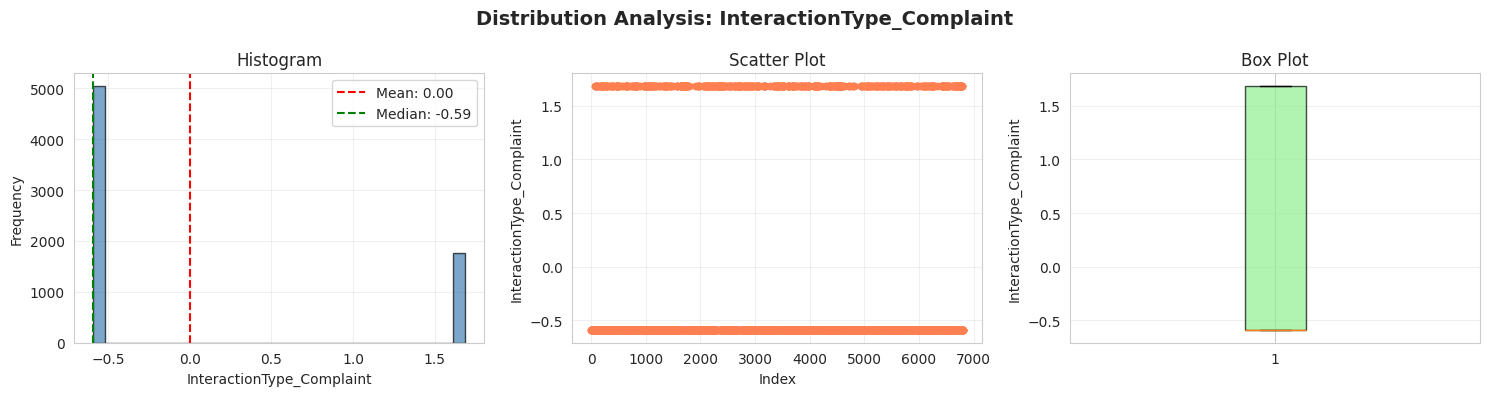


STATISTICS: InteractionType_Complaint
Mean:     0.000
Median:   -0.592
Std Dev:  1.000
Min:      -0.592
Max:      1.688
Skewness: 1.096
Kurtosis: -0.798
Outliers: 0 (0.00%)


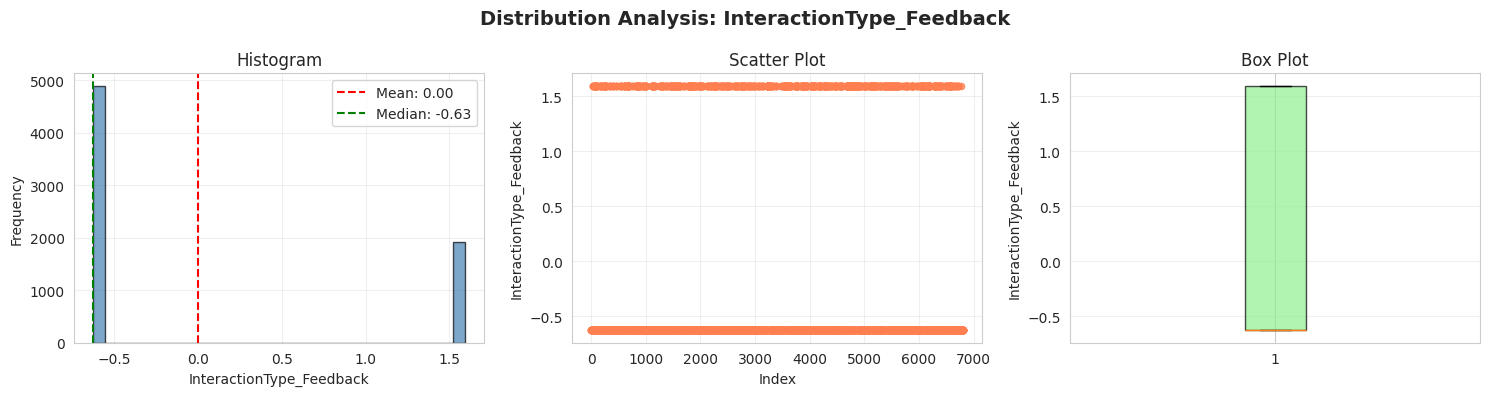


STATISTICS: InteractionType_Feedback
Mean:     0.000
Median:   -0.627
Std Dev:  1.000
Min:      -0.627
Max:      1.596
Skewness: 0.969
Kurtosis: -1.061
Outliers: 0 (0.00%)


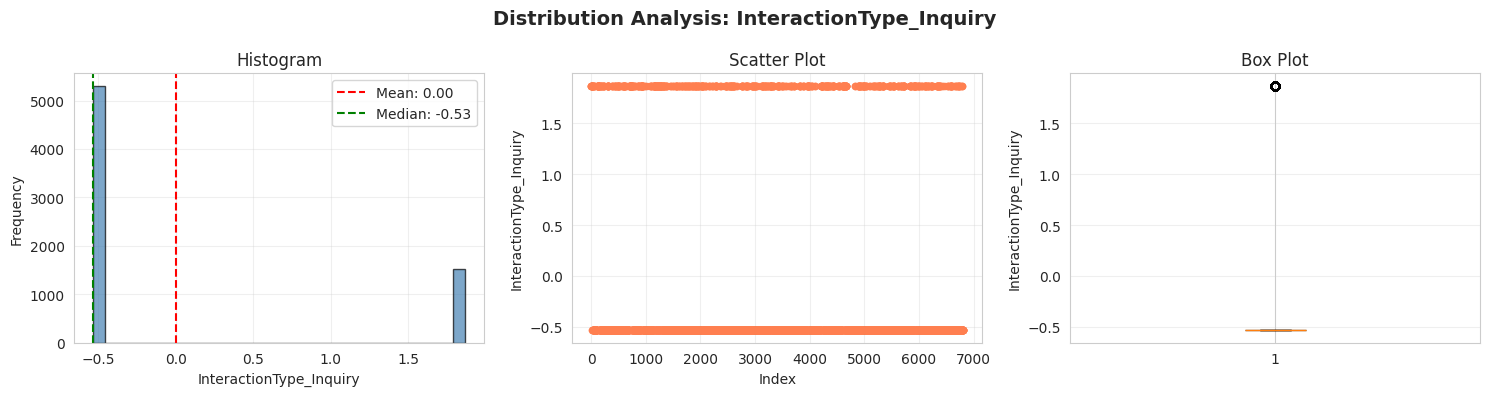


STATISTICS: InteractionType_Inquiry
Mean:     0.000
Median:   -0.535
Std Dev:  1.000
Min:      -0.535
Max:      1.871
Skewness: 1.336
Kurtosis: -0.214
Outliers: 1514 (22.23%)


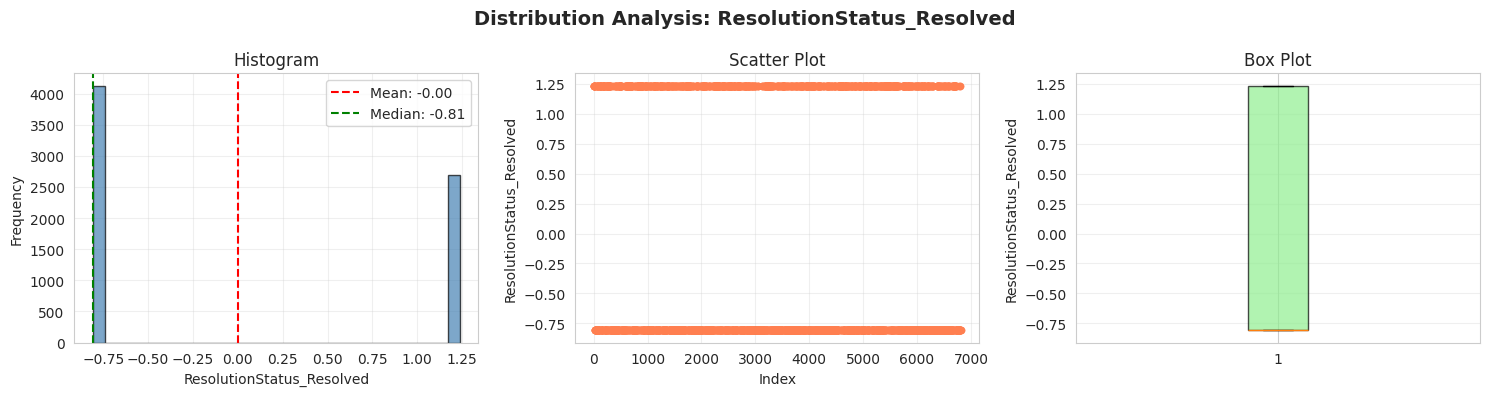


STATISTICS: ResolutionStatus_Resolved
Mean:     -0.000
Median:   -0.809
Std Dev:  1.000
Min:      -0.809
Max:      1.237
Skewness: 0.428
Kurtosis: -1.817
Outliers: 0 (0.00%)


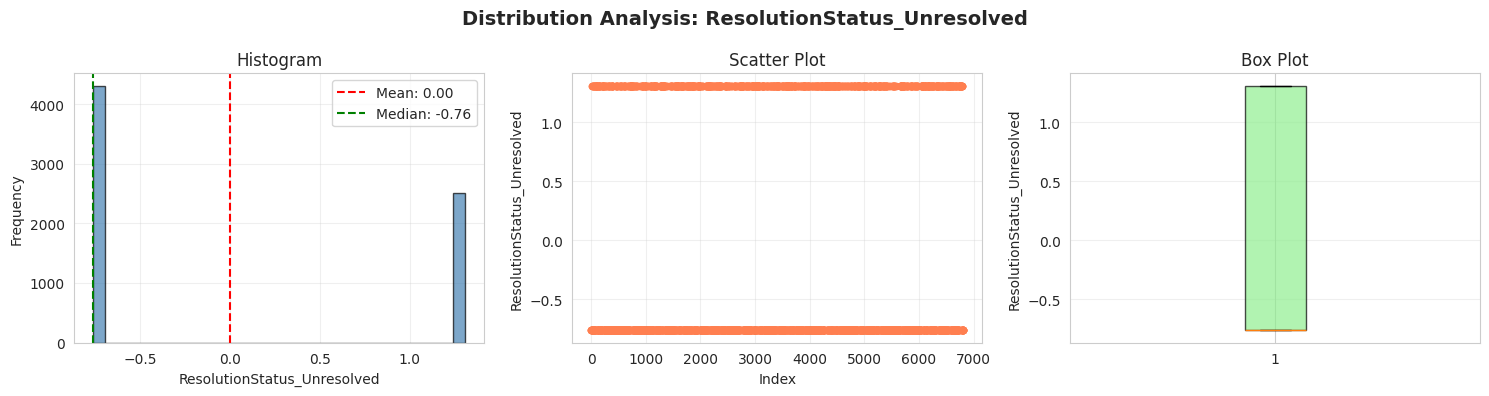


STATISTICS: ResolutionStatus_Unresolved
Mean:     0.000
Median:   -0.764
Std Dev:  1.000
Min:      -0.764
Max:      1.309
Skewness: 0.545
Kurtosis: -1.704
Outliers: 0 (0.00%)


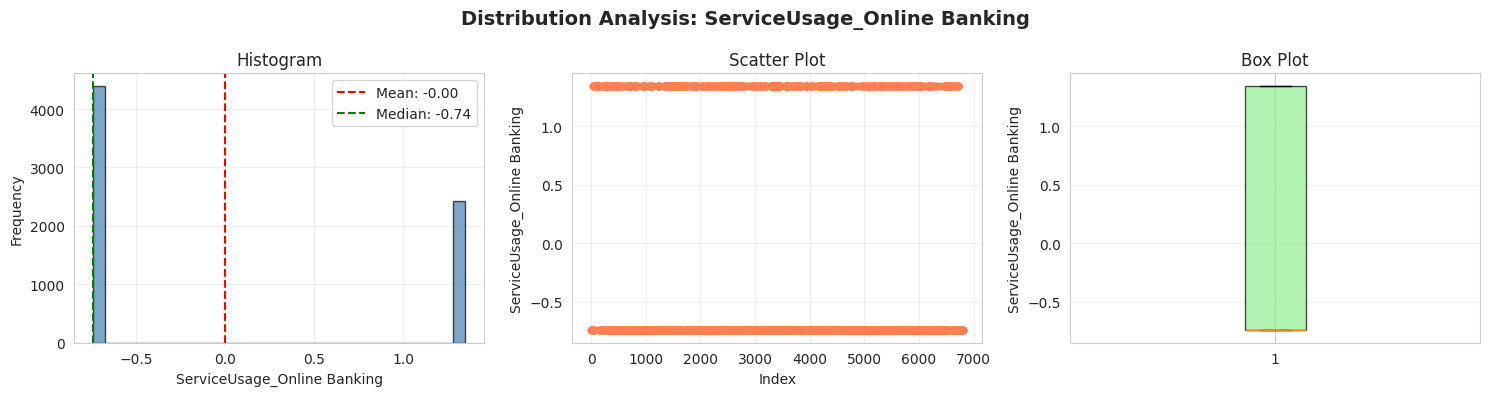


STATISTICS: ServiceUsage_Online Banking
Mean:     -0.000
Median:   -0.742
Std Dev:  1.000
Min:      -0.742
Max:      1.348
Skewness: 0.606
Kurtosis: -1.634
Outliers: 0 (0.00%)


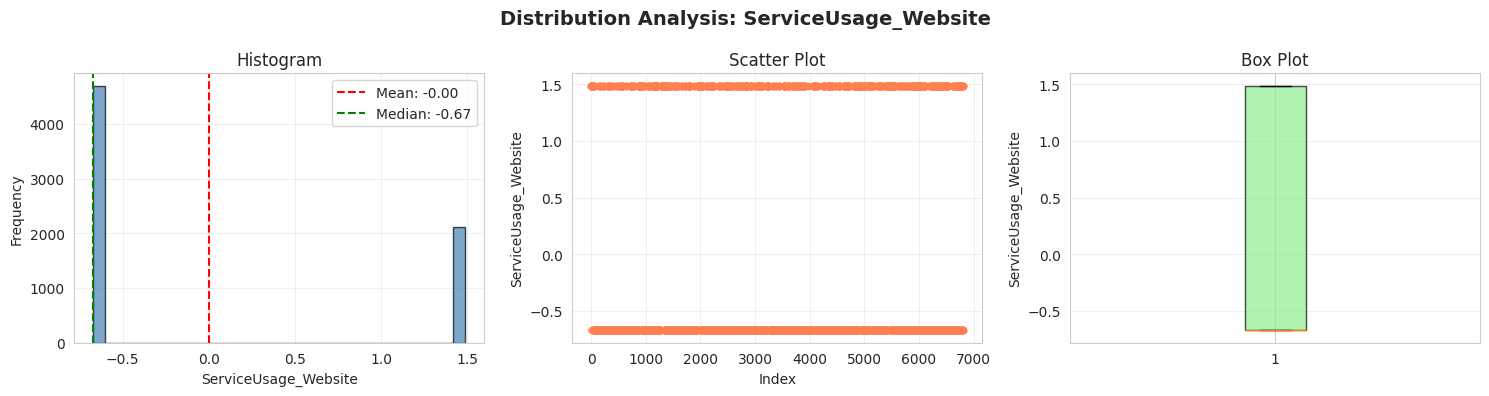


STATISTICS: ServiceUsage_Website
Mean:     -0.000
Median:   -0.672
Std Dev:  1.000
Min:      -0.672
Max:      1.488
Skewness: 0.816
Kurtosis: -1.335
Outliers: 0 (0.00%)

 ANALYZING FEATURES VS CHURN...

FEATURE ANALYSIS BY CHURN STATUS

Age:
  Retained - Mean: -0.022, Median: -0.018
  Churned  - Mean: 0.091, Median: 0.113
  Difference: 0.113
  T-test p-value: 0.0002 ***SIGNIFICANT***

AmountSpent:
  Retained - Mean: -0.003, Median: -0.003
  Churned  - Mean: 0.010, Median: 0.014
  Difference: 0.013
  T-test p-value: 0.6731 (not significant)

LoginFrequency:
  Retained - Mean: 0.050, Median: 0.162
  Churned  - Mean: -0.202, Median: -0.123
  Difference: -0.252
  T-test p-value: 0.0000 ***SIGNIFICANT***

Gender_F:
  Retained - Mean: 0.020, Median: 0.950
  Churned  - Mean: -0.081, Median: -1.052
  Difference: -0.101
  T-test p-value: 0.0009 ***SIGNIFICANT***

Gender_M:


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the o

  Retained - Mean: -0.020, Median: -0.950
  Churned  - Mean: 0.081, Median: 1.052
  Difference: 0.101
  T-test p-value: 0.0009 ***SIGNIFICANT***

MaritalStatus_Married:
  Retained - Mean: -0.009, Median: -0.553
  Churned  - Mean: 0.036, Median: -0.553
  Difference: 0.045
  T-test p-value: 0.1427 (not significant)


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],



MaritalStatus_Single:
  Retained - Mean: -0.013, Median: -0.538
  Churned  - Mean: 0.051, Median: -0.538
  Difference: 0.064
  T-test p-value: 0.0364 ***SIGNIFICANT***

MaritalStatus_Widowed:
  Retained - Mean: 0.012, Median: -0.621
  Churned  - Mean: -0.047, Median: -0.621
  Difference: -0.058
  T-test p-value: 0.0551 (not significant)

IncomeLevel_Low:
  Retained - Mean: -0.015, Median: -0.692
  Churned  - Mean: 0.062, Median: -0.692
  Difference: 0.077
  T-test p-value: 0.0114 ***SIGNIFICANT***

IncomeLevel_Medium:
  Retained - Mean: -0.010, Median: -0.706
  Churned  - Mean: 0.040, Median: -0.706
  Difference: 0.050
  T-test p-value: 0.1007 (not significant)

ProductCategory_Clothing:
  Retained - Mean: 0.007, Median: -0.497
  Churned  - Mean: -0.029, Median: -0.497
  Difference: -0.036
  T-test p-value: 0.2361 (not significant)


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the o


ProductCategory_Electronics:
  Retained - Mean: -0.014, Median: -0.501
  Churned  - Mean: 0.057, Median: -0.501
  Difference: 0.071
  T-test p-value: 0.0191 ***SIGNIFICANT***

ProductCategory_Furniture:
  Retained - Mean: -0.004, Median: -0.491
  Churned  - Mean: 0.015, Median: -0.491
  Difference: 0.019
  T-test p-value: 0.5280 (not significant)

ProductCategory_Groceries:
  Retained - Mean: 0.003, Median: -0.501
  Churned  - Mean: -0.011, Median: -0.501
  Difference: -0.014
  T-test p-value: 0.6428 (not significant)


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the o


InteractionType_Complaint:
  Retained - Mean: -0.008, Median: -0.592
  Churned  - Mean: 0.032, Median: -0.592
  Difference: 0.040
  T-test p-value: 0.1904 (not significant)

InteractionType_Feedback:
  Retained - Mean: -0.007, Median: -0.627
  Churned  - Mean: 0.028, Median: -0.627
  Difference: 0.034
  T-test p-value: 0.2587 (not significant)


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],



InteractionType_Inquiry:
  Retained - Mean: -0.002, Median: -0.535
  Churned  - Mean: 0.006, Median: -0.535
  Difference: 0.008
  T-test p-value: 0.7976 (not significant)

ResolutionStatus_Resolved:
  Retained - Mean: -0.009, Median: -0.809
  Churned  - Mean: 0.036, Median: -0.809
  Difference: 0.044
  T-test p-value: 0.1441 (not significant)

ResolutionStatus_Unresolved:
  Retained - Mean: -0.006, Median: -0.764
  Churned  - Mean: 0.024, Median: -0.764
  Difference: 0.030
  T-test p-value: 0.3250 (not significant)

ServiceUsage_Online Banking:
  Retained - Mean: -0.005, Median: -0.742
  Churned  - Mean: 0.018, Median: -0.742
  Difference: 0.023
  T-test p-value: 0.4503 (not significant)


/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
/tmp/ipython-input-25071257.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(15, 4))
/tmp/ipython-input-25071257.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],



ServiceUsage_Website:
  Retained - Mean: 0.030, Median: -0.672
  Churned  - Mean: -0.123, Median: -0.672
  Difference: -0.153
  T-test p-value: 0.0000 ***SIGNIFICANT***

 ANALYZING CORRELATIONS...


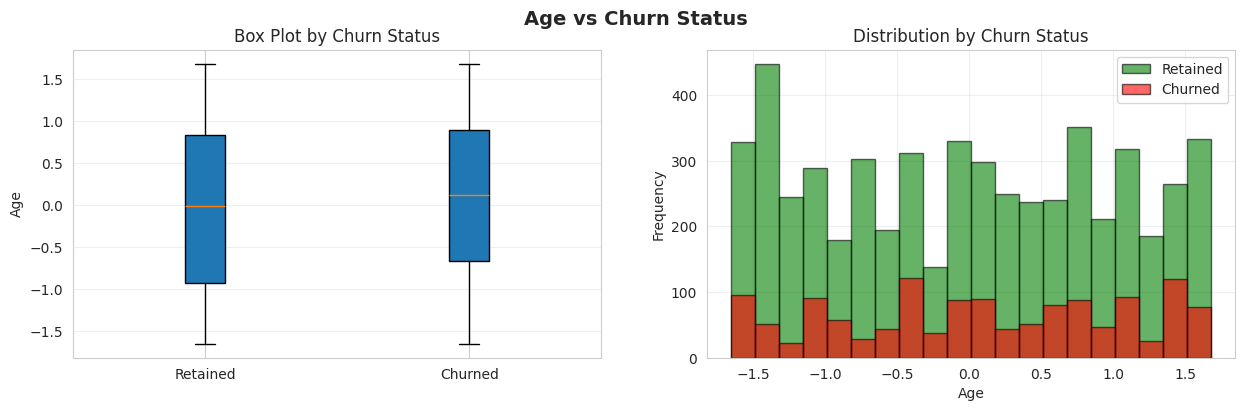

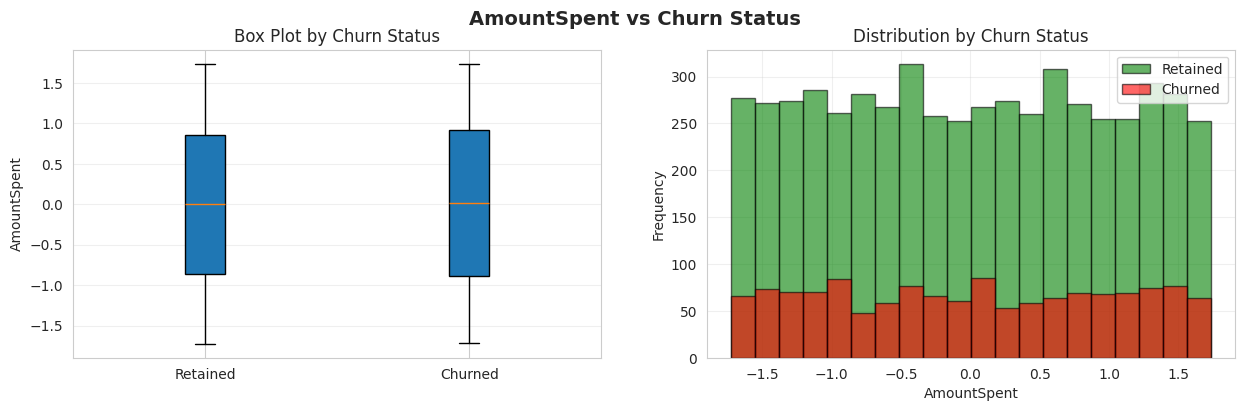

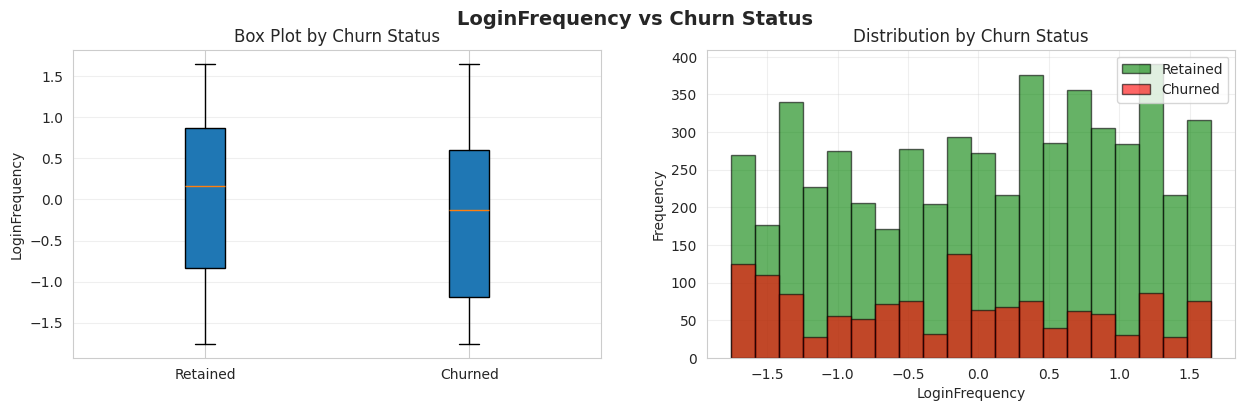

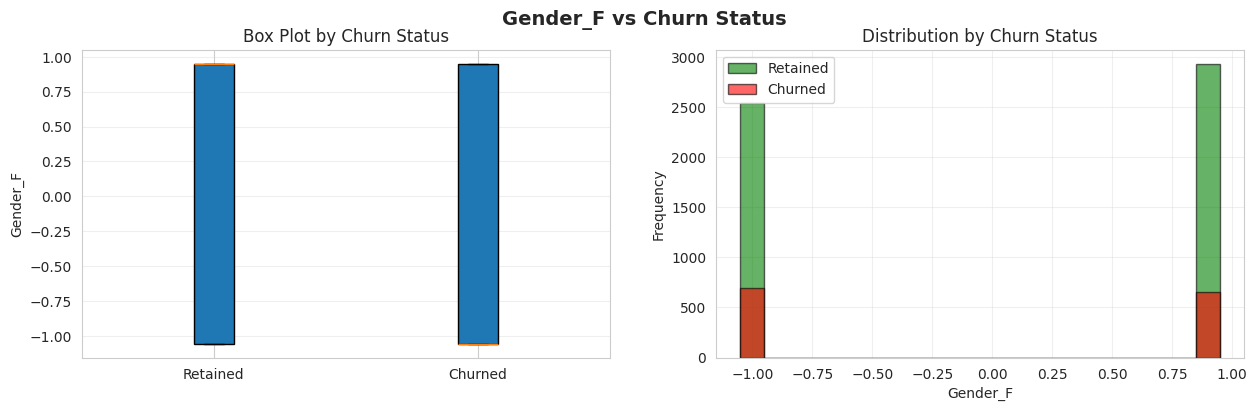

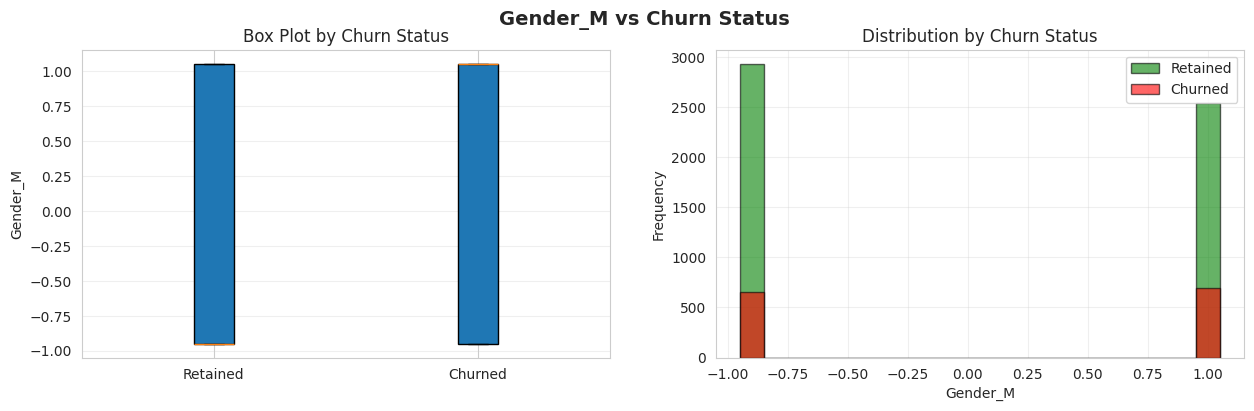

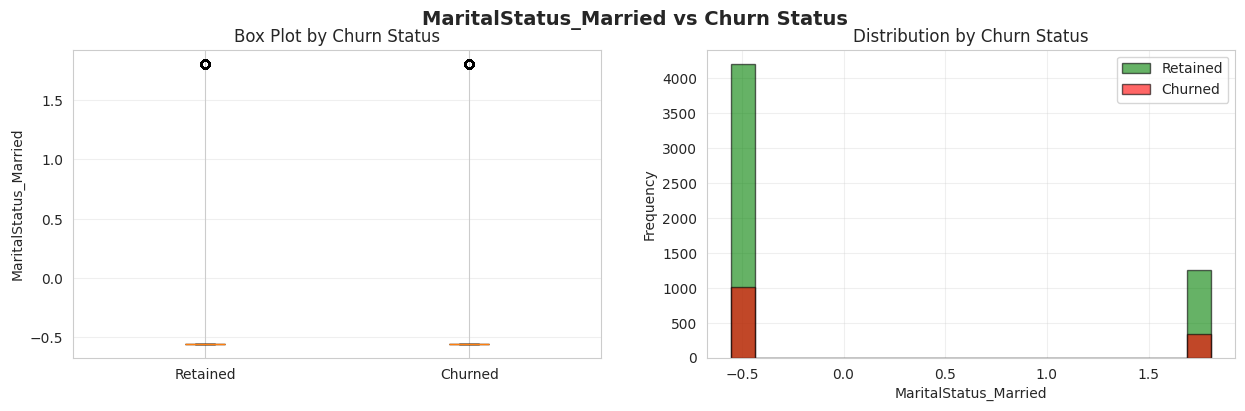

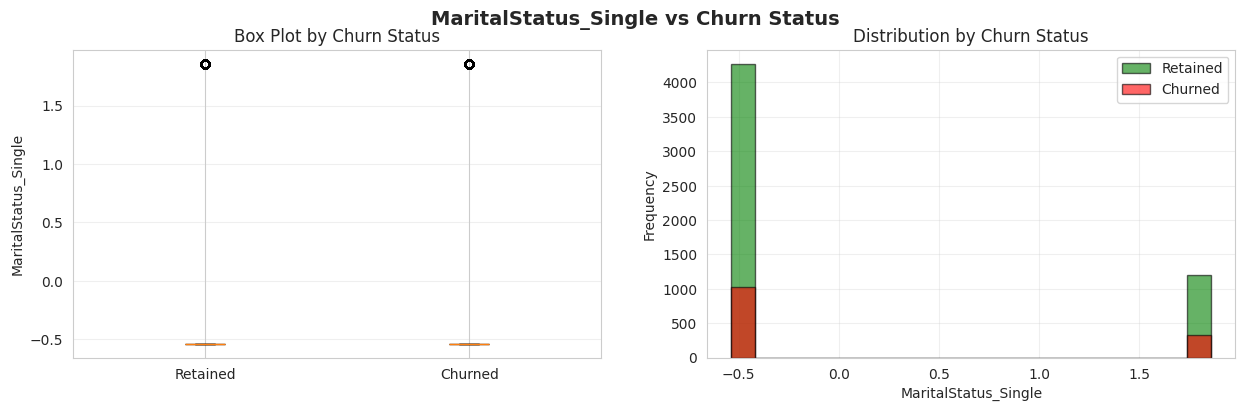

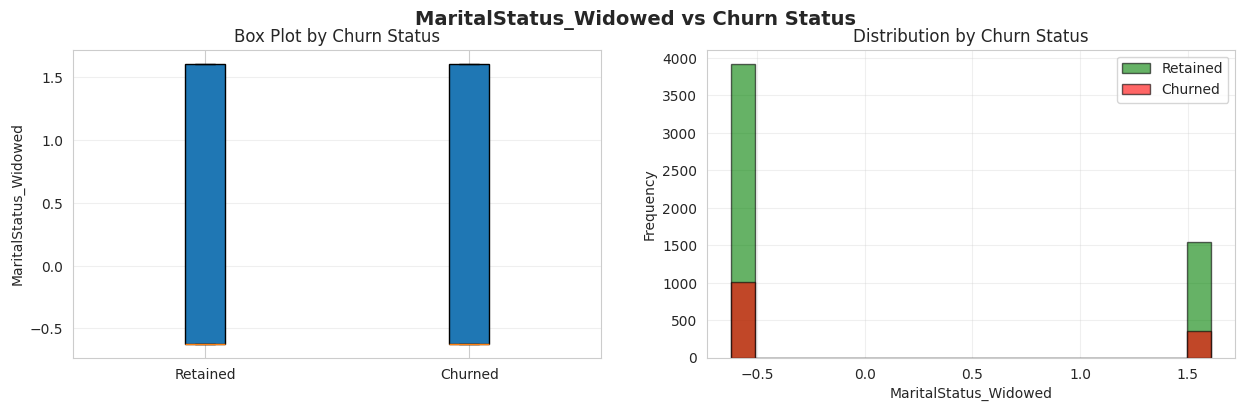

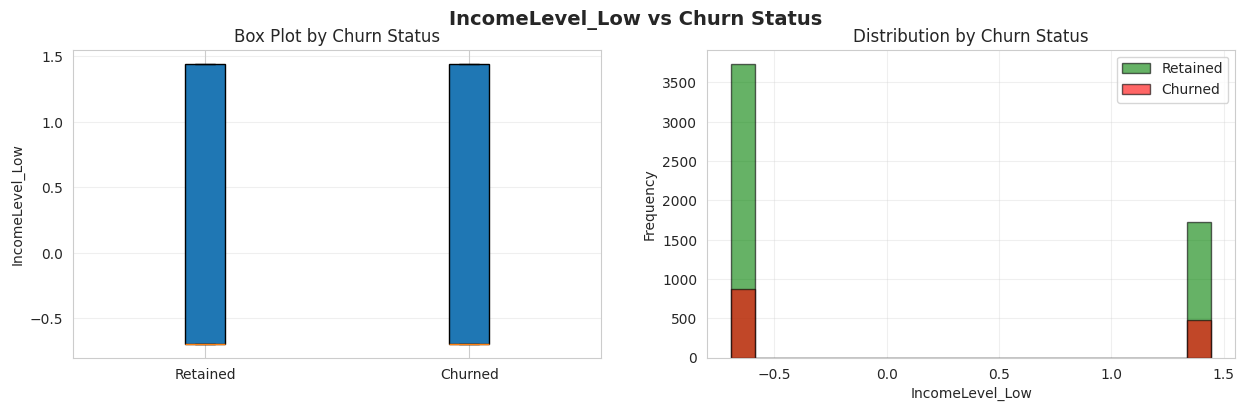

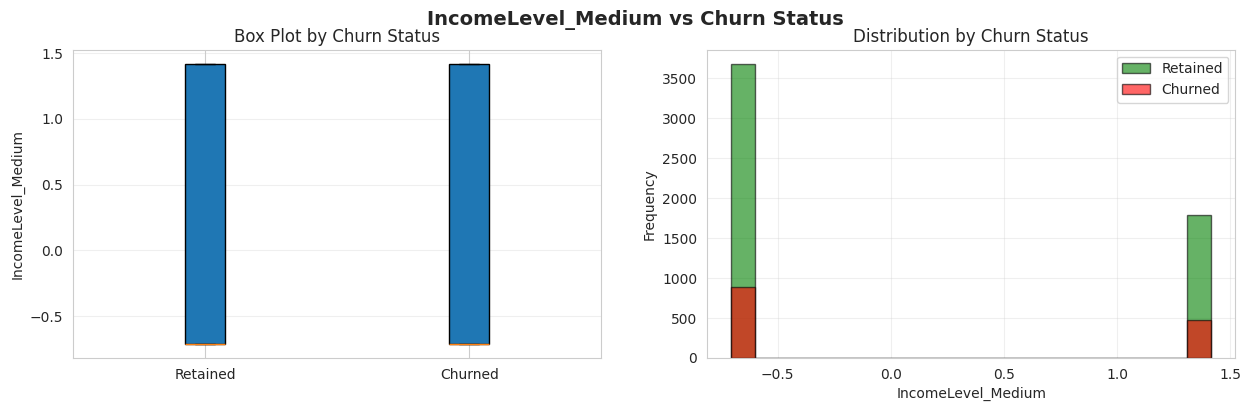

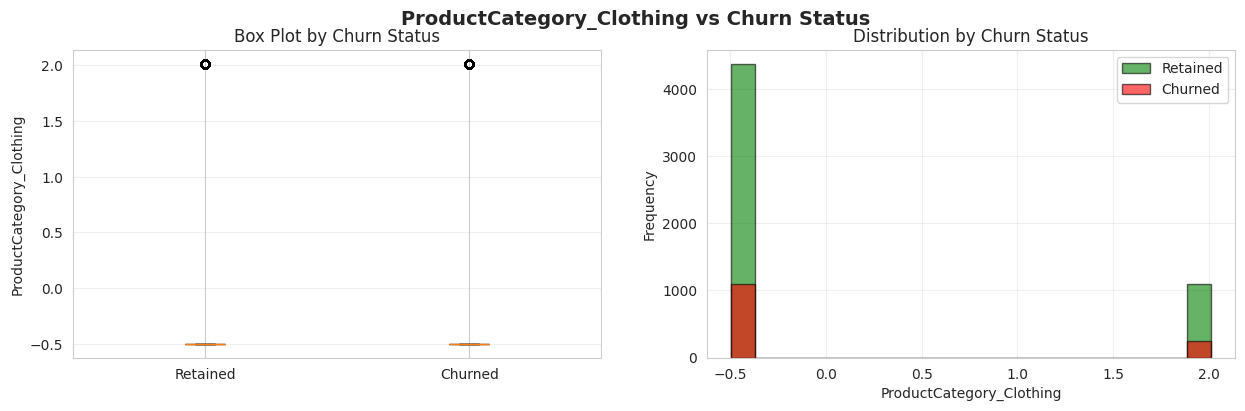

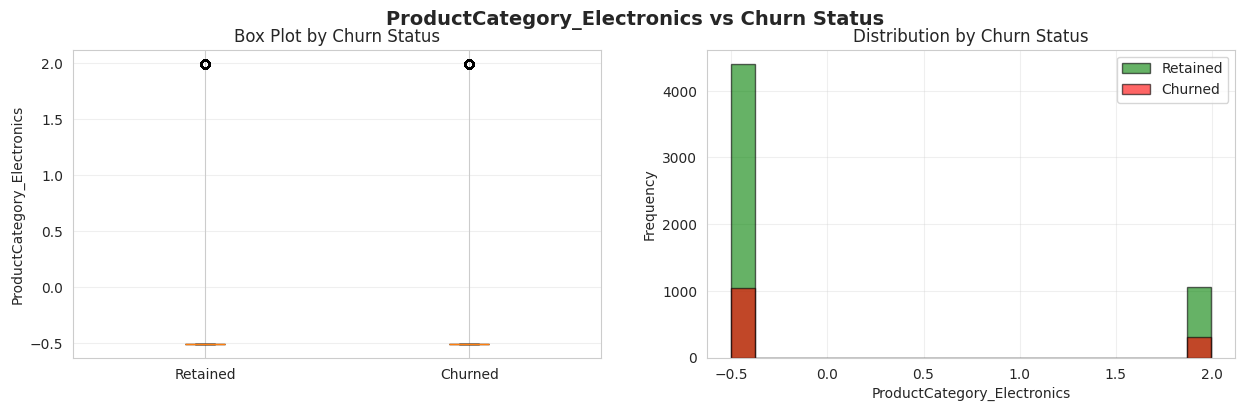

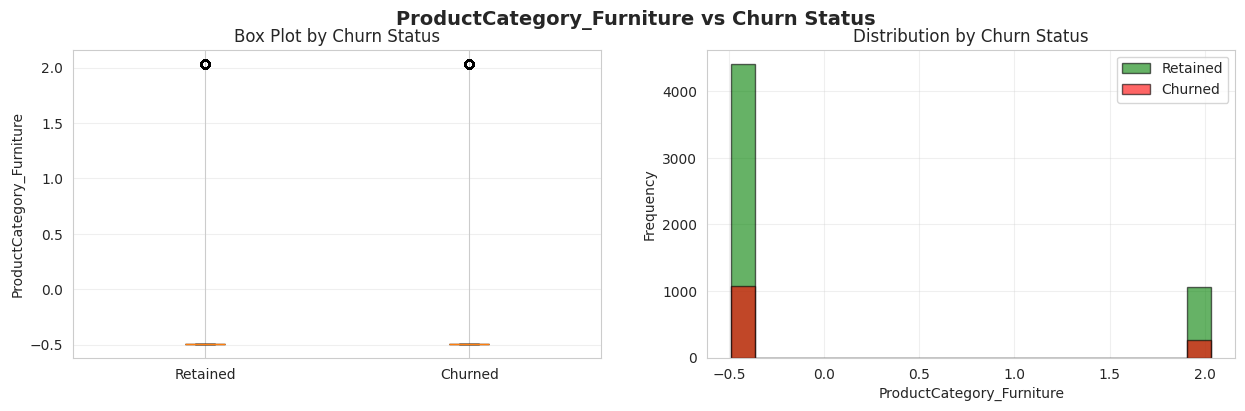

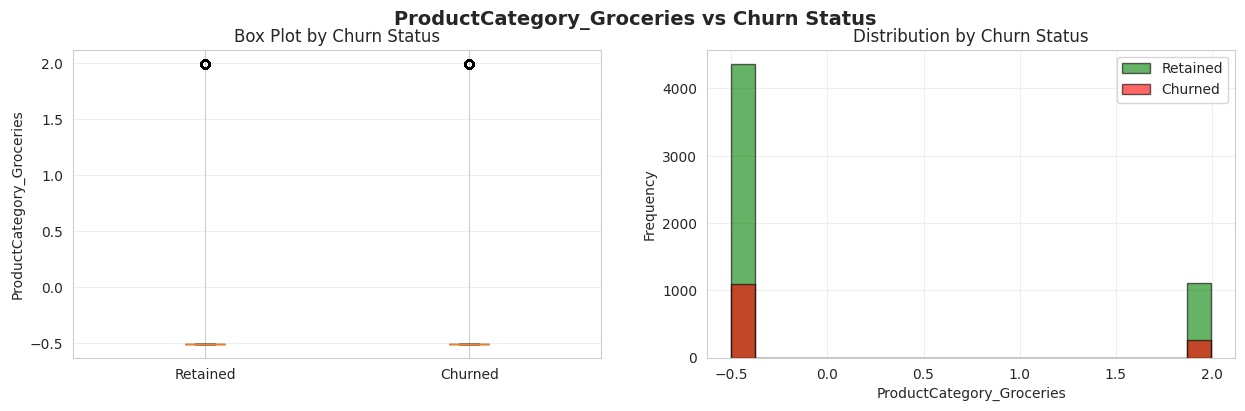

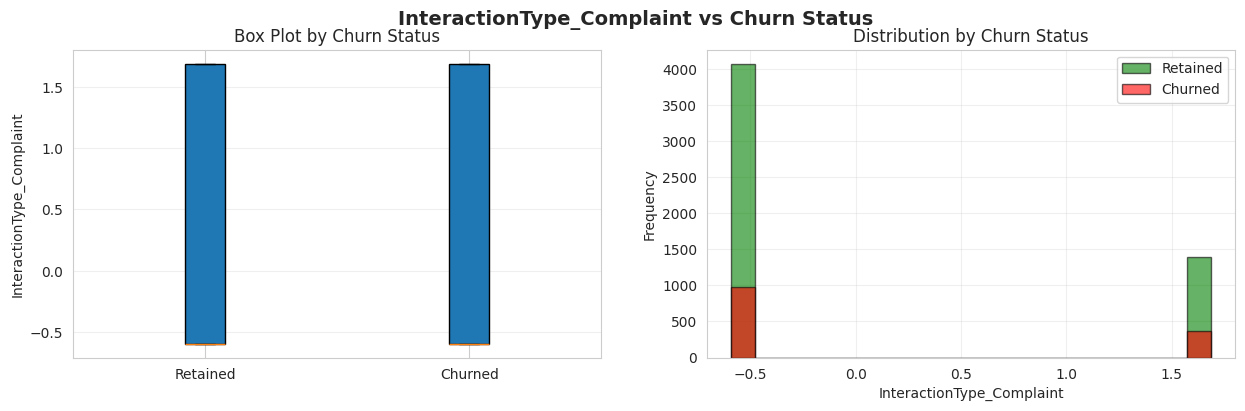

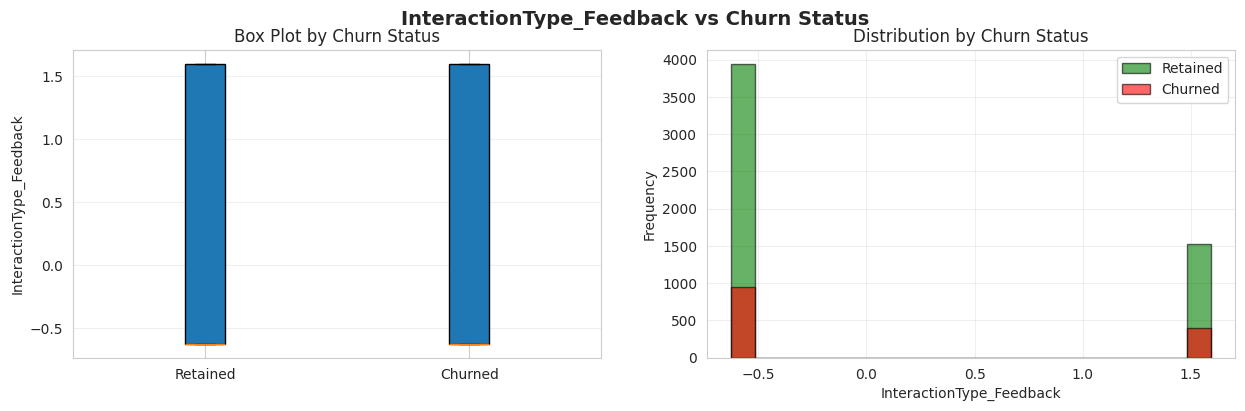

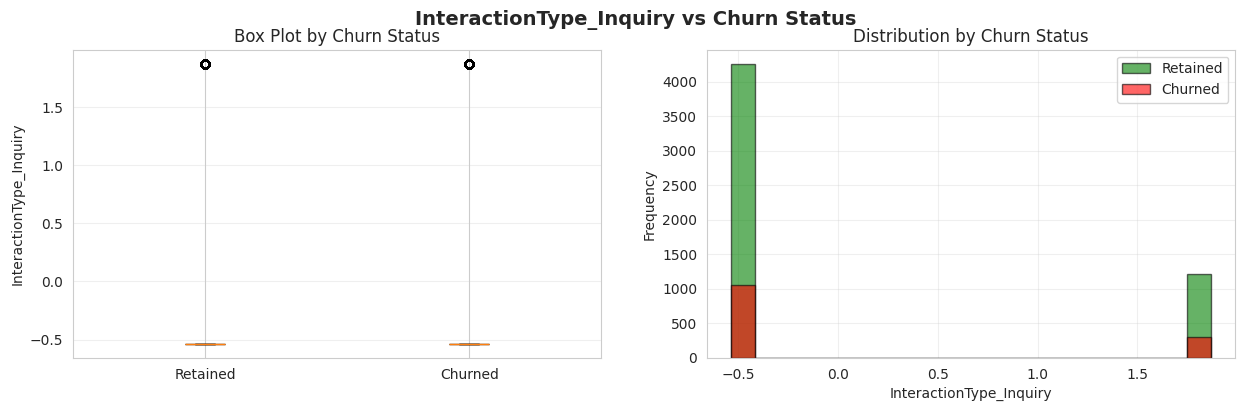

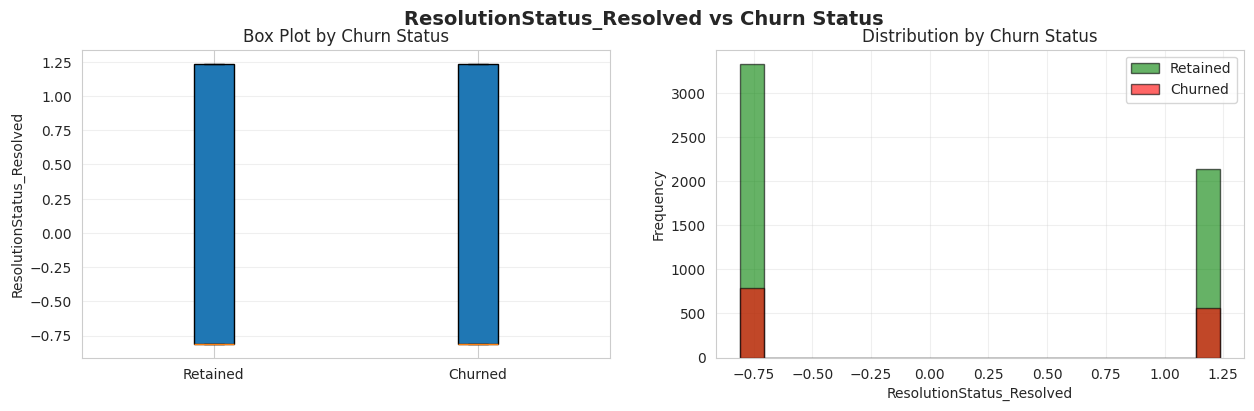

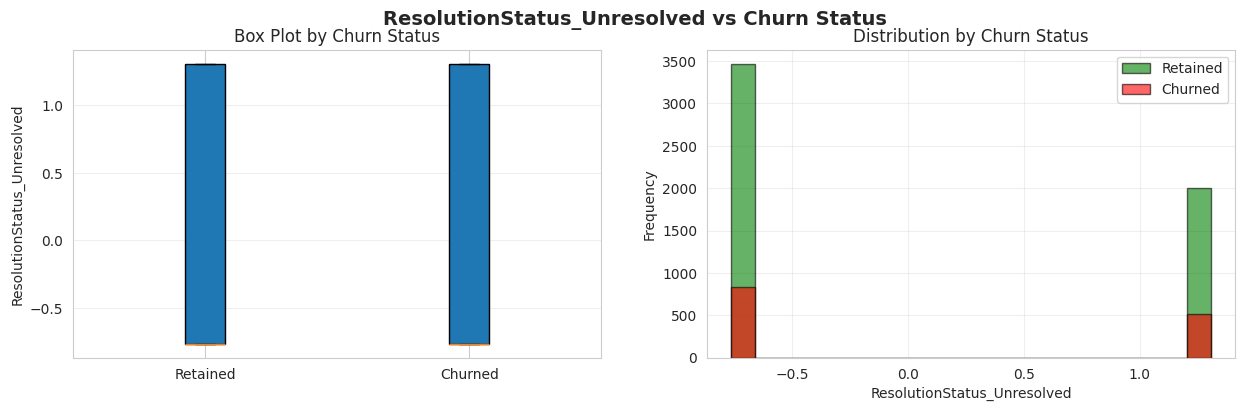

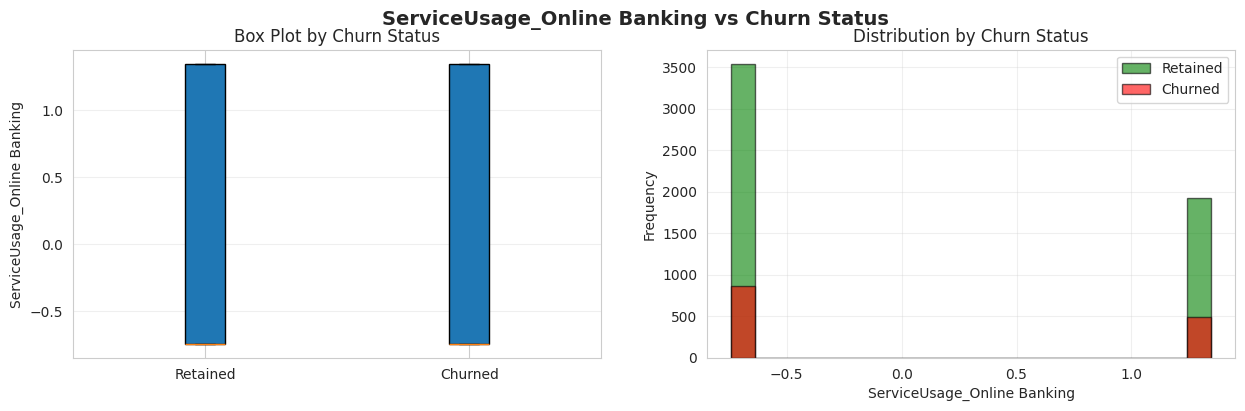

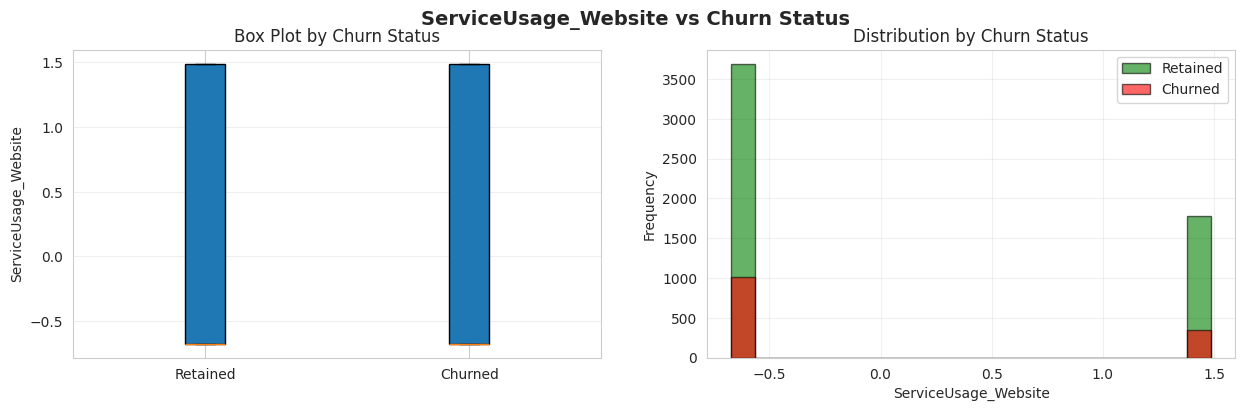

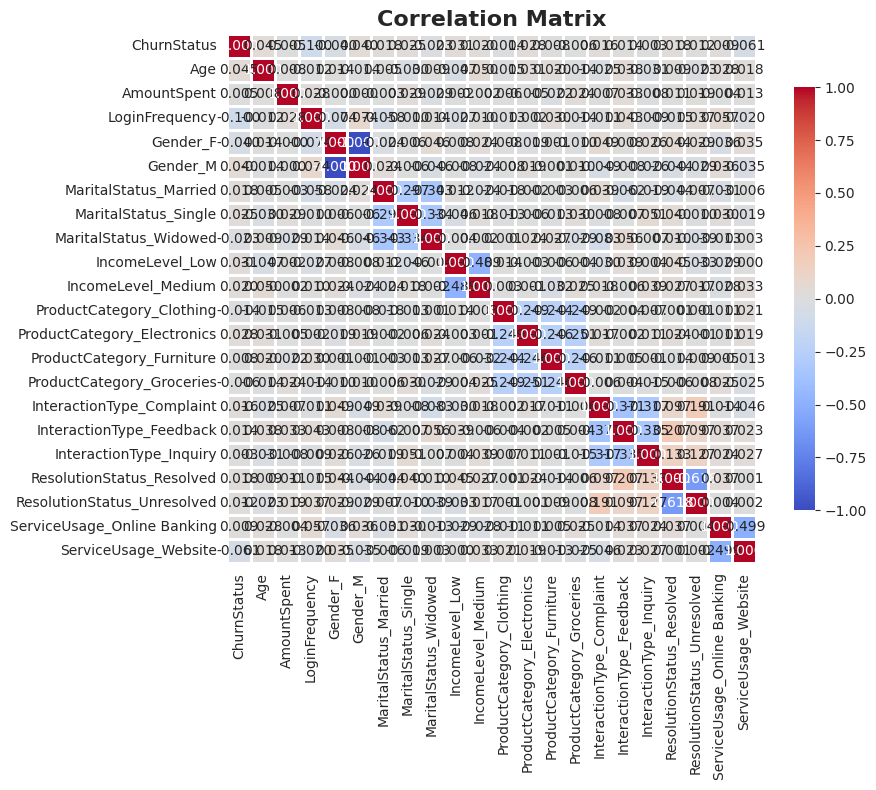


CORRELATION WITH CHURN STATUS
Age                            0.045048
Gender_M                       0.040196
IncomeLevel_Low                0.030648
ProductCategory_Electronics    0.028391
MaritalStatus_Single           0.025353
IncomeLevel_Medium             0.019889
MaritalStatus_Married          0.017761
ResolutionStatus_Resolved      0.017699
InteractionType_Complaint      0.015866
InteractionType_Feedback       0.013687
ResolutionStatus_Unresolved    0.011927
ServiceUsage_Online Banking    0.009147
ProductCategory_Furniture      0.007647
AmountSpent                    0.005113
InteractionType_Inquiry        0.003109
ProductCategory_Groceries     -0.005621
ProductCategory_Clothing      -0.014358
MaritalStatus_Widowed         -0.023245
Gender_F                      -0.040196
ServiceUsage_Website          -0.061023
LoginFrequency                -0.100391
Name: ChurnStatus, dtype: float64


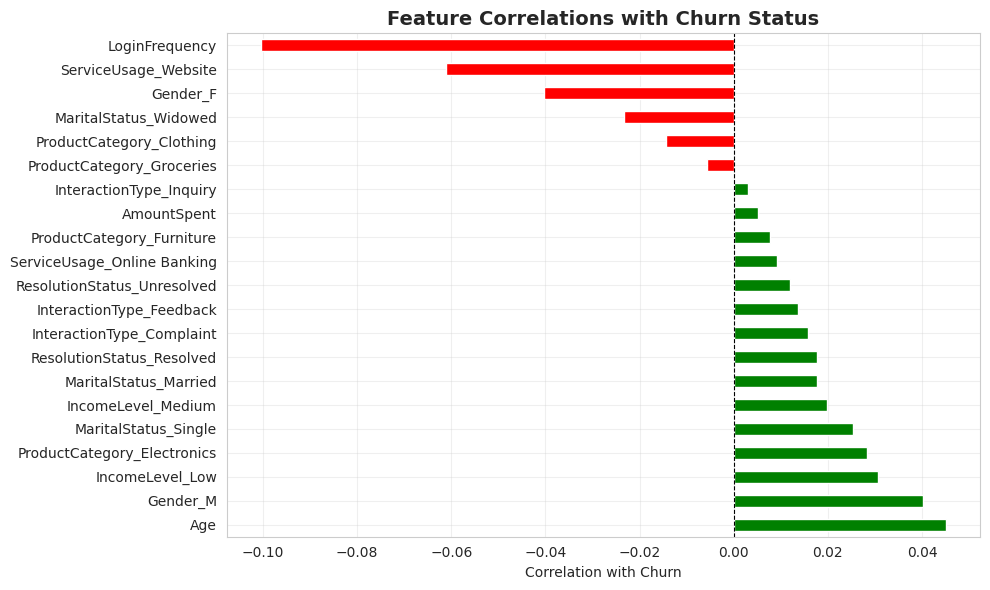


 CREATING SCATTER MATRIX...


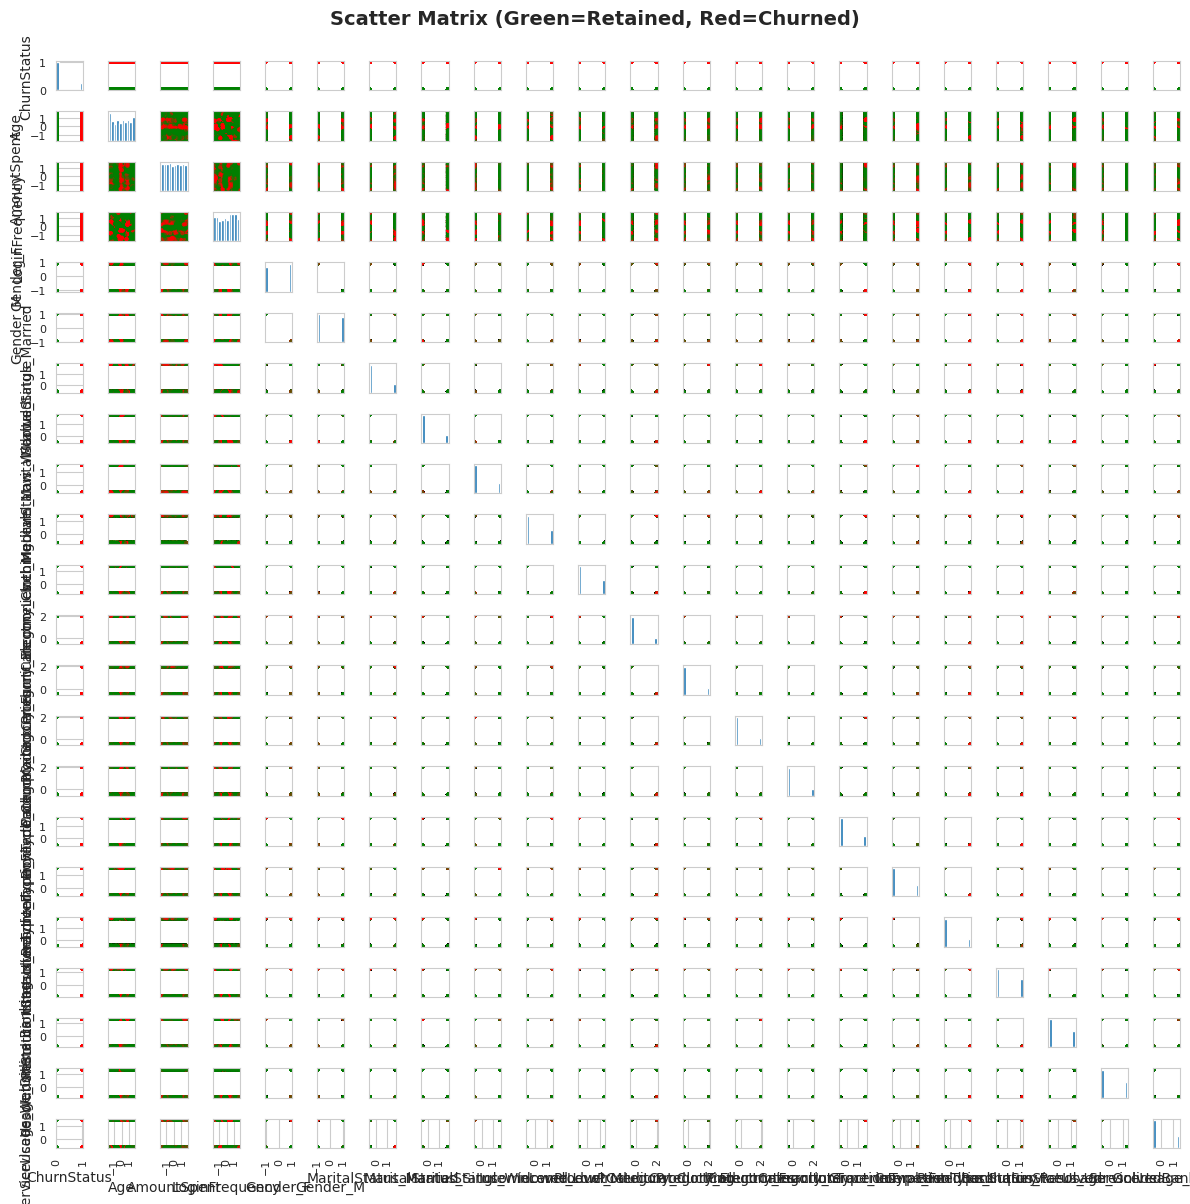


KEY INSIGHTS FOR CHURN PREDICTION

Feature Importance (sorted by effect size):

                    Feature  Churned_Mean  Retained_Mean  Difference      P_Value  Cohens_D  Significant
             LoginFrequency     -0.201745       0.049956   -0.251701 9.963310e-17  0.251186         True
       ServiceUsage_Website     -0.122632       0.030366   -0.152998 4.647129e-07  0.156576         True
                        Age      0.090527      -0.022416    0.112943 1.998570e-04  0.113797         True
                   Gender_M      0.080778      -0.020002    0.100780 9.056606e-04  0.100774         True
                   Gender_F     -0.080778       0.020002   -0.100780 9.056606e-04  0.100774         True
            IncomeLevel_Low      0.061589      -0.015251    0.076840 1.141808e-02  0.076237         True
ProductCategory_Electronics      0.057054      -0.014128    0.071182 1.911466e-02  0.070108         True
       MaritalStatus_Single      0.050949      -0.012616    0.063565 3.639934e-

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# 1. DATA OVERVIEW AND BASIC STATISTICS
# ============================================================================

def data_overview(df):
    """Print comprehensive data overview"""
    print("="*80)
    print("DATA OVERVIEW")
    print("="*80)
    print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumn Names and Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nBasic Statistics:\n{df.describe()}")
    print(f"\nChurn Distribution:\n{df['ChurnStatus'].value_counts()}")
    print(f"Churn Rate: {df['ChurnStatus'].mean()*100:.2f}%")
    print("="*80)

# ============================================================================
# 2. UNIVARIATE ANALYSIS - INDIVIDUAL FEATURE DISTRIBUTIONS
# ============================================================================

def plot_distributions(df, exclude_cols=['CustomerID']):
    """Create distribution plots for all numerical features"""
    numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col not in exclude_cols]

    for col in numerical_cols:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f'Distribution Analysis: {col}', fontsize=14, fontweight='bold')

        data = df[col].dropna()

        # Histogram
        axes[0].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
        axes[0].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.2f}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Histogram')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Scatter plot
        axes[1].scatter(range(len(data)), data, alpha=0.5, s=20, color='coral')
        axes[1].set_xlabel('Index')
        axes[1].set_ylabel(col)
        axes[1].set_title('Scatter Plot')
        axes[1].grid(True, alpha=0.3)

        # Box plot
        bp = axes[2].boxplot(data, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][0].set_alpha(0.7)
        axes[2].set_ylabel(col)
        axes[2].set_title('Box Plot')
        axes[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # Statistical analysis
        print(f"\n{'='*60}")
        print(f"STATISTICS: {col}")
        print(f"{'='*60}")
        print(f"Mean:     {data.mean():.3f}")
        print(f"Median:   {data.median():.3f}")
        print(f"Std Dev:  {data.std():.3f}")
        print(f"Min:      {data.min():.3f}")
        print(f"Max:      {data.max():.3f}")
        print(f"Skewness: {data.skew():.3f}")
        print(f"Kurtosis: {data.kurtosis():.3f}")

        # Identify outliers using IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
        print(f"Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")

# ============================================================================
# 3. BIVARIATE ANALYSIS - FEATURES VS CHURN
# ============================================================================

def analyze_features_vs_churn(df, exclude_cols=['CustomerID']):
    """Analyze relationship between features and churn"""
    numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col not in exclude_cols + ['ChurnStatus']]

    print("\n" + "="*80)
    print("FEATURE ANALYSIS BY CHURN STATUS")
    print("="*80)

    for col in numerical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        fig.suptitle(f'{col} vs Churn Status', fontsize=14, fontweight='bold')

        churned = df[df['ChurnStatus'] == 1][col].dropna()
        retained = df[df['ChurnStatus'] == 0][col].dropna()

        # Side-by-side box plots
        axes[0].boxplot([retained, churned], labels=['Retained', 'Churned'],
                        patch_artist=True)
        axes[0].set_ylabel(col)
        axes[0].set_title('Box Plot by Churn Status')
        axes[0].grid(True, alpha=0.3, axis='y')

        # Overlapping histograms
        axes[1].hist(retained, bins=20, alpha=0.6, label='Retained', color='green', edgecolor='black')
        axes[1].hist(churned, bins=20, alpha=0.6, label='Churned', color='red', edgecolor='black')
        axes[1].set_xlabel(col)
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution by Churn Status')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Statistical comparison
        print(f"\n{col}:")
        print(f"  Retained - Mean: {retained.mean():.3f}, Median: {retained.median():.3f}")
        print(f"  Churned  - Mean: {churned.mean():.3f}, Median: {churned.median():.3f}")
        print(f"  Difference: {churned.mean() - retained.mean():.3f}")

        # T-test for significance
        t_stat, p_value = stats.ttest_ind(churned, retained)
        print(f"  T-test p-value: {p_value:.4f} {'***SIGNIFICANT***' if p_value < 0.05 else '(not significant)'}")

# ============================================================================
# 4. CORRELATION ANALYSIS
# ============================================================================

def correlation_analysis(df, exclude_cols=['CustomerID']):
    """Analyze correlations between features"""
    numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col not in exclude_cols]

    # Correlation matrix
    corr_matrix = df[numerical_cols].corr()

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Correlation with churn
    print("\n" + "="*80)
    print("CORRELATION WITH CHURN STATUS")
    print("="*80)
    churn_corr = corr_matrix['ChurnStatus'].drop('ChurnStatus').sort_values(ascending=False)
    print(churn_corr)

    # Visualize correlations with churn
    plt.figure(figsize=(10, 6))
    churn_corr.plot(kind='barh', color=['green' if x > 0 else 'red' for x in churn_corr])
    plt.xlabel('Correlation with Churn')
    plt.title('Feature Correlations with Churn Status', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. MULTIVARIATE ANALYSIS
# ============================================================================

def scatter_matrix_analysis(df, exclude_cols=['CustomerID']):
    """Create scatter plot matrix"""
    numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col not in exclude_cols]

    # Create scatter matrix colored by churn status
    colors = df['ChurnStatus'].map({0: 'green', 1: 'red'})
    pd.plotting.scatter_matrix(df[numerical_cols], figsize=(12, 12),
                               alpha=0.6, diagonal='hist', c=colors)
    plt.suptitle('Scatter Matrix (Green=Retained, Red=Churned)', fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 6. KEY INSIGHTS SUMMARY
# ============================================================================

def generate_insights(df, exclude_cols=['CustomerID']):
    """Generate key insights about churn predictors"""
    print("\n" + "="*80)
    print("KEY INSIGHTS FOR CHURN PREDICTION")
    print("="*80)

    numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col not in exclude_cols + ['ChurnStatus']]

    insights = []

    for col in numerical_cols:
        churned = df[df['ChurnStatus'] == 1][col].dropna()
        retained = df[df['ChurnStatus'] == 0][col].dropna()

        # T-test
        t_stat, p_value = stats.ttest_ind(churned, retained)

        # Effect size (Cohen's d)
        pooled_std = np.sqrt((churned.std()**2 + retained.std()**2) / 2)
        cohens_d = abs(churned.mean() - retained.mean()) / pooled_std

        insights.append({
            'Feature': col,
            'Churned_Mean': churned.mean(),
            'Retained_Mean': retained.mean(),
            'Difference': churned.mean() - retained.mean(),
            'P_Value': p_value,
            'Cohens_D': cohens_d,
            'Significant': p_value < 0.05
        })

    insights_df = pd.DataFrame(insights).sort_values('Cohens_D', ascending=False)
    print("\nFeature Importance (sorted by effect size):\n")
    print(insights_df.to_string(index=False))

    print("\n" + "="*80)
    print("RECOMMENDATIONS:")
    print("="*80)

    significant_features = insights_df[insights_df['Significant']]
    if len(significant_features) > 0:
        print("\nMost important features for predicting churn:")
        for _, row in significant_features.head(3).iterrows():
            direction = "higher" if row['Difference'] > 0 else "lower"
            print(f"  • {row['Feature']}: Churned customers have {direction} values "
                  f"(difference: {row['Difference']:.3f}, p={row['P_Value']:.4f})")

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_full_eda(df):
    """Run complete exploratory data analysis"""
    print("\n" + "STARTING COMPREHENSIVE EDA FOR CUSTOMER CHURN" + "\n")

    # 1. Data Overview
    data_overview(df)

    # 2. Distribution Analysis
    print("\n ANALYZING FEATURE DISTRIBUTIONS...")
    plot_distributions(df)

    # 3. Churn Analysis
    print("\n ANALYZING FEATURES VS CHURN...")
    analyze_features_vs_churn(df)

    # 4. Correlation Analysis
    print("\n ANALYZING CORRELATIONS...")
    correlation_analysis(df)

    # 5. Multivariate Analysis
    print("\n CREATING SCATTER MATRIX...")
    scatter_matrix_analysis(df)

    # 6. Generate Insights
    generate_insights(df)

    print("\n EDA COMPLETE!")

run_full_eda(data_preprocessed)


#Final selection

In [ ]:
#Chosen Features
features = ['LoginFrequency',
'Age',
'AmountSpent',
'IncomeLevel_Medium',
'ServiceUsage_Online Banking',
'IncomeLevel_Low',
'MaritalStatus_Widowed',
'MaritalStatus_Single',
'MaritalStatus_Married',
'ServiceUsage_Website',
'InteractionType_Feedback',
'ResolutionStatus_Unresolved',
'ResolutionStatus_Resolved',
'InteractionType_Complaint',
'InteractionType_Inquiry',
'Gender_F',
'Gender_M']

df_final = data_preprocessed[features]

df_final.to_csv('customer_churn_processed.csv')